<h1><h1>
<center> Data Science Coursework 2: supervised and unsupervised methods <center>

<a name="outline"></a>
## Outline

- [0](#intro) Introduction
- [Task 1](#task-1): Neural networks
  - [1.0](#q10) Loading and preparing the data
  - [1.1](#q11) Multi-layer perceptron
      - [1.1.1](#q111) Implementation
      - [1.1.2](#q112) Exploration of the effect of the learning rate
      - [1.1.3](#q113) Exploration of the effect of the number of epochs
  - [1.2](#q12) Convolutional neural network (CNN)
      - [1.2.1](#q121) Implementation
      - [1.2.2](#q122) Dropout regularisation
      - [1.2.3](#q123) Comparison to MLP
      - [1.2.4](#q124) Feature maps
- [Task 2](#task-2): Unsupervised learning
  - [2.1](#q21) Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data
      - [2.1.1](#q211) Implementation of PCA
      - [2.1.2](#q212) Finding the optimal number of ptincipal components
      - [2.1.3](#q213) Representing the data in two dimensions
      - [2.1.4](#q214) Clustering the two dimensional data
  - [2.2](#q22) Clustering of the feature matrix
      - [2.2.1](#q221) Implementation of the hierarchical clustering algorithm
      - [2.2.2](#q222) Evaluation measures: the silhouette score
  - [2.3](#q23) Graph-based analysis 
      - [2.3.1](#q231) Spectral clustering
      - [2.3.2](#q232) Measures of centrality: a comparison
      - [2.3.3](#q233) Comparison of results to _Lusseau et al._
- [3](#q3) Conclusion
- [4](#q4) References

<a name="intro"></a>
# Introduction [^](#outline)

<a name="task-1"></a>
# Task 1: Neural networks [^](#outline)

In [1]:
# imports for neural networks
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

<a name="q10"></a>
## 1.0 Loading and preparing the data [^](#outline)

In this section, we work with the `fashion MNIST` dataset. This contains a train and test dataset with observations of size `(60000, 28, 28)`, i.e. 60000 28x28 images, and labels of size `(60000, 10)`. The data is categorical and we have 10 categories.

We first load the data using the `load_data` function. It contains a scaling step and performs the same sclaing on both the train and test data to ensure comparability. We also convert the labels into a collection of binary arrays acting as indicators for the class index. This is done to ensure that the data format is approprate for out loss function.

We then have an initial look at the data by visualizing a representative of each class. This gives us an indication of the hardness of the classification task. We see that each image contains only one fashion item, and the shapes stand out of the picture due to the dark background. With a further exploration of the data, I found that each picture is positioned at the middle of the image and there are no translations/rotations of the shapes. This means that our neural network models need not to have equivariance properties for these transformations to do well.

After loading the data, we flatten the 28x28 images in the training dataset. This is necessary to implement the Multi-layer perceptron. Hence the dimensions of the training dataset become `(60000, 784)`.

In [2]:
# loading data
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return ((x_train, y_train), (x_test, y_test))

(x_train, y_train), (x_test, y_test) = load_data()
print(f'shape of x_train: {x_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of x_test: {x_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of x_train: (60000, 28, 28)
shape of y_train: (60000, 10)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000, 10)


Text(0.5, 1, 'A representative of each label class')

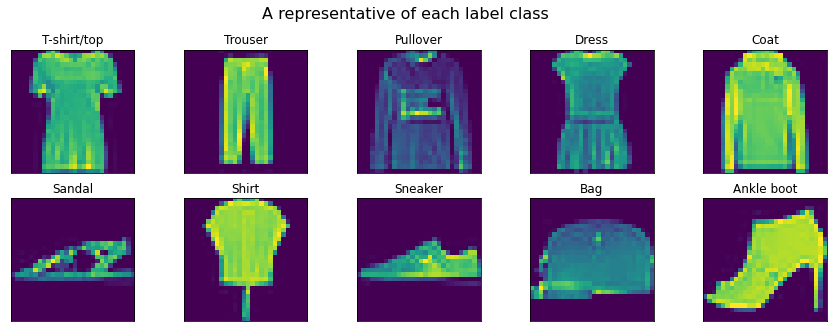

In [104]:
# plot an image from each class
label_dict = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
              6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,5))

labels = []
j = -1
while len(labels) < 10:
    for i, ax in enumerate(axs.reshape(-1)):
        j += 1
        if (np.where(y_train[j]==1)[0][0]==i):
            if i not in labels:
                labels.append(i)
                ax.imshow(x_train[j])
                ax.set_title(f"{label_dict[i]}")
                ax.set_xticks([])
                ax.set_yticks([])
plt.suptitle("A representative of each label class", fontsize=16, y=1)

In [3]:
#flattening data
x_train_flat = np.zeros((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
for i in range((x_train.shape[0])):
    x_train_flat[i, :] = x_train[i, :, :].flatten()

x_test_flat = np.zeros((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))
for i in range((x_test.shape[0])):
    x_test_flat[i, :] = x_test[i, :, :].flatten()

print(f'shape of x_train_flat: {x_train_flat.shape}')
print(f'shape of x_test_flat: {x_test_flat.shape}')

shape of x_train_flat: (60000, 784)
shape of x_test_flat: (10000, 784)


<a name="q11"></a>

## 1.1 Multi-layer perceptron [^](#outline)

The multi-layer perceptron is the simplest type of deep learning model. It consists of layers of mathematical neurons, linked together in a directed acyclic graph. It carries out a series of linear regression models that are put together using composition. Each linear transformation is carried out in a layer of the network, with the use of the neurons. The complexity of the network ensures that the model is able to learn fundamental features of the data, such as edges, roundedness and so on. 

<a name="q111"></a>
### 1.1.1 Implementation [^](#outline)

In the following cells, we implement a Multi-layer perceptron. I have chosen to implement the model as a class object in order to store the parameters in a clear way. The first cell defines loss and activation functions that are not strictly part of the model and hence will be called from the outside.

### _a) Mapping to the implemented functions_

The model thus consists of the following constituents. We map these to the auxiliary functions and methods of the MLP class.
- __Parameters.__ The network was weight (W) and bias (b) parameters, one of each, corresponding to each layer. These are initialized in the `get_params` method via Glorot initialisation. The dimension of the parameters depends on the layer sizes and is specified in the corresponding methods. 
- __Layers.__ We implement 5 dense layers and one output layer of sizes (784, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 10), respectively. The layer transformations are carried out in the dense method. 
- _Activation functions._ These are the `leaky_reLU` and the `softmax` functions. `leaky_reLU` is used between the layers, `softmax` is used to convert model predictions into probabilities.
- __Forward pass.__ This is carried out in the `forward_pass` method. It propagates the input data through the model by successively performing the transformations given by the layers.
- __Optimization steps.__ These are used to compute the gradient of the loss and carry out stochastic gradient descent.
    - __Loss function.__ We use categorical cross entropy, and implement it in the function `categorical_crossentropy`
    - __Calculation of the output error.__ This is in the `output_error` function. It is required to obtain the gradients of the loss (with respect to the parameters) via the chain rule, and is the starting point og the backpropagation method. Please see the derivation of the output error below.
    - __Backpropagation.__ This is implemented in the `backward_pass` and `grads` methods. The backpropagation is used to compute the gradients of the loss with respect to the pre-activations, also known as the errors. The algorithm passes through the neurons backwards. The method backward_pass only does one step backwards, while grads calls it to produce all gradients.
    - __Optimization algorithm.__ We use stochastic gradient descent, see the `SGD` method. The method `fit` is slightly redundant but was added for clarity. It calls `SGD` and returns the fitted parameters, the loss and accuracy of its predictions (both for the train and the validation dataset).
    
### _b) Mapping to the mathematical formulas_
    
Before we implement the model, some definitions need to be made precise. Let $K$ be the number of hidden layers in the model (in our specific case, this is 5). We use the following form of the categorical cross-entropy loss function:
$$
L(\theta) = -\frac{1}{|\mathcal{D}_{train}|} \sum_{x_i\in\mathcal{D}_{train}}\sum_{j=1}^{10} \tilde{y}_{ij} \ln f_\theta(x_i)_j,
$$

where $f_\theta$ is the function representing the neural network (with parameters $\theta$) that outputs a length 10 probability vector $f_\theta(x_i)\in\mathbb{R}^{10}$ for an input example image $x_i\in\mathbb{R}^{28\times 28}$, and $\tilde{y}_{ij}$ is 1 if the correct label for example $i$ is $j$, and 0 otherwise. This form is suitable for the structure of the data we have, however it is equivalent to
$$L(y;\hat{y}) = -\sum_{i=1}^{10} y_i \cdot \log(\hat{y}_i)$$

The activation function used for the output layer is the softmax, given by
$$\hat{y}_j =  \frac{e^{a^{(K+1)}_j}}{\sum_{i = 1}^{10} e^{a^{(K+1)}_i}},$$

where $(K+1)$ gives the index of the output layer, $\hat{y}_j, 1 \leq j \leq 10$ stands for the predicted probabilities and $a$ are the pre-activations of the output layer. We note that this combination of softmax and categorical cross-entropy is ideal for balanced data, and our data is balanced. In these cases, this results in a loss function that is relatively easy to optimize.

We also give the used mathematical formulas for the forward pass, backward pass and gradient calculations. These are all presented in matrix form and were modified to accommodate the dimensions of our data. For example, since each data sample has dimension `(1, 784)`, `x_batch` needs to be multiplied by W from the right.

__1. One step of the forward pass:__
$$a^{(k+1)} = h^{(k)}W^{(k)}+b^{(k)},$$
where k is the layer index.

__2. Backpropagation:__
$$\left(\delta^{(k)}\right) = \sigma'(a^{(k)}) \left[\delta^{(k+1)} (W^{(k)})^T \right],$$
where $\sigma'(a^{(k)}) = \text{diag}\left(\left[\sigma'(a_j^{(k)}) \right]_{j=1}^{n_k} \right),$ where n_k is the dimension of $a^{(k)}$, which is dependent on $k$.

__3. Gradient calculation:__
$$\frac{\partial L}{\partial W^{(k)}} =\left[h^{(k)}\right]^T \delta^{(k+1)}$$
$$\frac{\partial L}{\partial b^{(k)}}= \delta^{(k+1)}.$$
 
### _c) Derivation of the output error formula_

The output error needs to be derived in order to be able to initalize the backpropagation step.  The output error is defined as $\delta^{(K+1)} := \frac{\partial L}{\partial a^{(K+1)}}$. Using the chain rule, we have

$$
\begin{align*}
\delta^{(K+1)} :=
\frac{\partial L(y;\hat{y})}{\partial a_{j}^{(K+1)}}
&= \frac{\partial L}{\partial \hat{y}_i}\frac{\partial \hat{y}_i}{\partial a_j^{(K+1)}} \\
&= -\sum_{i=1}^{10} y_i \cdot \frac{\partial\log(\hat{y}_i)}{\partial \hat{y}_i} \frac{\partial \hat{y}_i}{\partial a_j^{(K+1)}}\\
&= -\sum_{i=1}^{10} y_i \cdot \frac{1}{\hat{y}_i}\cdot \frac{\partial \hat{y}_i}{\partial a_j^{(K+1)}}
\end{align*}.
$$

It remains to find $\frac{\partial \hat{y}_i}{\partial a_j^{(K+1)}}$. Due to the form of the softmax function, there are two different cases.

__1. Case 1:__ $i=j$
$$\frac{\partial \hat{y}_i}{\partial a_i^{(K+1)}} = \frac{e^{a^{(K+1)}_i} \cdot \Big(\sum_{i = 1}^{10} e^{a^{(K+1)}_i} \Big) - e^{a^{(K+1)}_i} \cdot e^{a^{(K+1)}_i}}{\Big(\sum_{i = 1}^{10} e^{a^{(K+1)}_i}\Big)^2} = \hat{y}_i(1-\hat{y}_i)$$

__2. Case 2:__ $i \neq j$
$$\frac{\partial \hat{y}_i}{\partial a_j^{(K+1)}} = \frac{0 - e^{a^{(K+1)}_i} \cdot e^{a^{(K+1)}_j}}{\Big(\sum_{i = 1}^{10} e^{a^{(K+1)}_i}\Big)^2} =- \hat{y}_i \cdot \hat{y}_j$$

Combining all this, we obtain
$$
\begin{align*}
\frac{\partial L(y;\hat{y})}{\partial a_{j}^{(K+1)}} &= -\sum_{i=1}^{10} y_i \cdot \frac{1}{\hat{y}_i}\cdot \frac{\partial \hat{y}_i}{\partial a_j^{(K+1)}}\\
&= -y_j \cdot \frac{\hat{y}_j(1-\hat{y}_j)}{\hat{y}_j} + \sum_{i\neq j} y_i \cdot \frac{\hat{y}_i\hat{y}_j}{\hat{y}_i}\\
&= -y_j+y_j\hat{y}_j + \sum_{i\neq j} y_i \hat{y}_j\\
&= -y_j + \hat{y}_j\sum_{i=1}^{10}y_i \\
&= \hat{y}_j - y_j.
\end{align*}
$$

In the second step, we took the case $i=j$ in front, in the fourth step, we put them back together and in the last step we used the fact that the $y_i$-s sum to 1.

In [4]:
def categorical_crossentropy(y_prob, y_true):
    """Calculate the categorical cross entropy of a prediction.
    
    Inputs:
    y_prob: ndarray of size (batch_size, 10)
            - contains the probabilities of each data row belonging to each class
            - batch_size is the number of data samples the model is run on
    y_true: ndarray of size (batch_size, 10)
            - contains the true label for each data sample as a binary vectos

    Returns:
    loss: float, the categorical cross entropy loss of the prediction
    """
    assert y_prob.shape == y_true.shape
    loss = np.mean(-np.sum(y_true * np.log(y_prob), axis=1))
    return loss
    
def leaky_reLU(a):
    """Return the LeakyReLU activation of the input pre-activation.
    
    Input:
        a: ndarray of shape (output_neurons,)
           - output_neurons is the number of neurons outputted by the layer.
           i.e. a layer of size (786, 400) has 400 output neurons
    Returns:
        h: ndarray of shape (output_neurons,)
    
    The function is vectorized.
    """
    h = np.maximum(0.01*a, a)
    return h

def softmax(x):
    """Return the softmax activation of the input."""
    n = x.shape[0]
    # numerically stable implementation
    e_x = np.exp(x - np.max(x))
    if len(x.shape)>1:
        # ensures that softmax works on matrices
        den = np.expand_dims(np.sum(e_x, axis=1), axis=1)  
    else:
        # ensures that softmax works on arrays
        den = np.sum(e_x)  
    return e_x / den
    
def output_error(y_prob, y_train):
    """Return the output error for the model.
    
    Inputs:
        y_prob: ndarray of size (batch_size, 10)
                - model predictions in terms of probabilities
        y_train: ndarray of size (batch_size, 10)
                - true labels of data samples stored in binary vectors
    Returns:
        delta_output: ndarray of size (batch_size, 10), the output error
    """
    assert y_prob.shape==y_train.shape
    delta_output = y_prob - y_train
    return delta_output

def activation_derivative(a):
    """Return the derivative of the LeakyReLU function."""

    return np.nan_to_num(np.maximum(a, 0.01*a)/a, copy=True, nan=0.0, posinf=None, neginf=None)

Text(0.5, 1, 'The activation functions of the Multi-layer perceptron model')

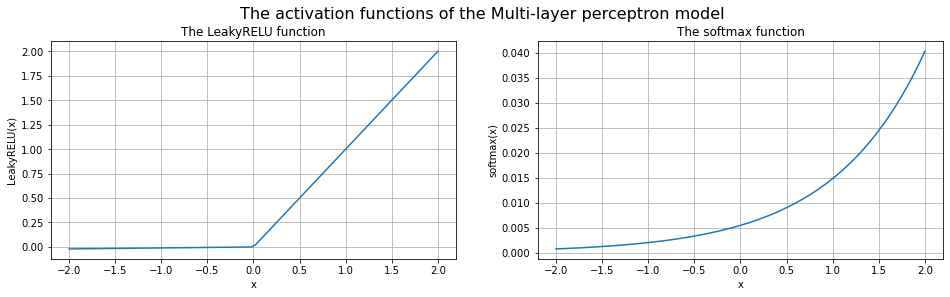

In [5]:
# plotting the activation functions for a sanity check
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(np.linspace(-2, 2, 100),leaky_reLU(np.linspace(-2, 2, 100)))
plt.xlabel("x")
plt.ylabel("LeakyRELU(x)")
plt.title("The LeakyRELU function")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(np.linspace(-2, 2, 100),softmax(np.linspace(-2, 2, 100)))
plt.xlabel("x")
plt.ylabel("softmax(x)")
plt.grid()
plt.title("The softmax function")
plt.suptitle("The activation functions of the Multi-layer perceptron model", fontsize=16, y=1)

In [6]:
class MLP:
    def __init__(self, x_train, y_train, x_test, y_test):
        """Initialize class with data and parameters.
        
        x_train: np.ndarray of shape (60000, 784)
        y_train: np.ndarray of shape (60000, 10)
        
        W: list of W matrices, these reflect the shape of the layers:
          - W0 for input layer of shape (784, 400)
          - W1,... W4 for other hidden layers (4) of shape (400, 400)
          - W5 for output layer of shape (400, 10)
        b: list of bias arrays, these reflect the shape of the layers:
          - b0 for input layer of shape (400, )
          - b1,... b4 for other hidden layers (4) of shape (400,)
          - b5 for output layer of shape (10,)
        """
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
        W0, b0 = self.get_params(784, 400)
        W1, b1 = self.get_params(400, 400)
        W2, b2 = self.get_params(400, 400)
        W3, b3 = self.get_params(400, 400)
        W4, b4 = self.get_params(400, 400)
        W5, b5 = self.get_params(400, 10)

        self.W = [W0, W1, W2, W3, W4, W5]
        self.b = [b0, b1, b2, b3, b4, b5]
    
    def get_params(self, n, m):
        """Initialize the model parameters using Glorot initialisation.
        
        Inputs:
            n, m: integers specifying the size of the matrices.
        
        Returns:
            W: ndarray of shape (n, m), the weights
            b: ndarray of shape (m,), the biases
        """
        var = 2. / (n + m)
        W = np.random.randn(n, m) * np.sqrt(var)
        b = np.zeros(m)
        return W, b
    
    def dense(self, x_batch, W, b):
        """Return the pre-activation obtained in a dense layer.
        
        Inputs:
            x_batch: ndarray of size (batch_size, input_neurons)
                    - batch_size: the number of samples chosen to propagate forward the model
                    - input_neurons: number of neurons at the start the current layer
            W: ndarray of size (input_neurons, output_neurons)
                    - input_neurons is either 784 or 400
                    - output_neurons is either 400 or 10
            b: ndarray of size (output_neurons,)
        
        Returns:
            a: ndarray of size (output_neurons,) giving the pre-activations
        """
        
        a = b + x_batch @ W
        return a
    
    def forward_pass(self, x_batch):
        """Propagate the model forward to get the predicted probabilities.
        
        Input:
            x_batch: ndarray of size (batch_size, input_neurons)
                     - batch_size: the number of samples chosen to propagate forward the model
                     - input_neurons: number of neurons at the start the current layer
            x_batch gives the starting data of the neural network.
        
        Returns:
            y: ndarray of size (10,), the predicted probabilities
            a: list of length 5 containing the pre-activations for each layer
               - elements have shape (output_neurons,)
            h: list of length 6 containing the post-activations for each layer
               - elements have shape (output_neurons,)
               - convention: h[0] = x_batch
        """
        n = len(self.W)
        a, h = [], [x_batch]

        for i in range(n-1):
            x_batch = self.b[i] + x_batch @ self.W[i]
            a.append(x_batch)
            x_batch = leaky_reLU(x_batch)
            h.append(x_batch)
        x_batch = x_batch @ self.W[-1] + self.b[-1]
        a.append(x_batch)
        
        return softmax(x_batch), h, a
        
    
    def backward_pass(self, delta_output, a):
        """Perform the backpropagation algorithm.
        Inputs:
            delta_output: ndarray of size (batch_size, output_neurons) giving the errors
                   - this is the most recent error in the backpropagation
                   - output_neurons is either 10 (for last layer) or 400 (for all other layers)
            a: array of shape (output_neurons,) giving the pre-activations
        Returns:
            deltas: list of length 5 containing ndarrays of size (batch_size, input_neurons)
                   - input_neurons is either 400 or 789 (first layer)
        """
        
        deltas = [delta_output]
        n = len(self.W)
        for i in range(n-1):
            deltas.append(activation_derivative(a[n-i-2]) * (deltas[i] @ self.W[n-i-1].T))
        
        return deltas[::-1]
        
    
    def grads(self, delta_output, a, h):
        """Calculate the gradients of the loss with respect to all weights and biases.
        
        Input:
            delta_output: ndarray of shape (batch_size, 10), the output error
            a: list of length 5 containing the pre-activations for each layer
               - elements have shape (output_neurons,)
            h: list of length 6 containing the post-activations for each layer
               - elements have shape (output_neurons,)
               - convention: h[0] = x_batch
            verbose: bool, if True, model prints the loss, train and test accuracies in each epoch
        
        Returns:
            grads_W: list of length 6 containing gradient matrices with respect to the weights for all layers
                     - element shapes (from index 0): 
                       (786, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 10) 
            grads_b: list of length 6 containing gradient matrices with respect to the biases for all layers
                     - element shapes (from index 0): 
                       (400,), (400,), (400,), (400,), (400,), (10,)    
        """
        
        deltas = self.backward_pass(delta_output, a)
        grads_W = [(h_val.T @ d/d.shape[0]) for (h_val, d) in zip(h, deltas)]  # produces mean
        grads_b = [np.expand_dims(np.mean(d, axis = 0), axis=0) for d in deltas]

        return grads_W, grads_b

    
    def SGD(self, batch_size=256, epochs=20,  learning_rate=1e-3, verbose=False):
        """Optimize the weight (W) and bias parameters (b) using stochastic gradient descent.
        
        Input:
            batch_size: integer, <= 60000, gives the size of batches the model should be optimized on
            epochs: integer, the number of traversals over the whole data (in batches)
            learning_rate: integer, gives the step size in stochastic gradient descent
        
        Returns:
            self.W: list of length 6 containing the optimized weight matrices for each layer
            self.b: list of length 6 containing the optimized bias vectors for each layer
            loss_per_epoch: array of size (epochs,), contains the average loss over the batches for each epoch
        """
        # initialise starting cost as infinity
        prev_cost = np.inf

        # stochastic gradient descent
        indices = np.arange(self.y_train.shape[0])
        indices_test = np.arange(self.y_test.shape[0])
        loss_per_epoch = np.zeros(epochs)
        train_acc_per_epoch = np.zeros(epochs)
        test_acc_per_epoch = np.zeros(epochs)
        
        for epoch in tqdm(range(epochs)):
            #shuffle to prevent repeating update cycles
            np.random.shuffle(indices)
            batches = np.array_split(indices, len(indices)//(batch_size-1))
            
            batches_test = np.array_split(indices_test, len(indices_test)//(batch_size-1))
            losses = []
            for batch_idx in batches:
                x_batch, y_batch = self.x_train[batch_idx], self.y_train[batch_idx]     
                y_prob, h, a = self.forward_pass(x_batch)
                delta_output_i = output_error(y_prob, y_batch)
                losses.append(categorical_crossentropy(y_prob, y_batch))
                W_grad, b_grad = self.grads(delta_output_i, a, h)
                
                self.W = [i - learning_rate*j for (i,j) in zip(self.W, W_grad)]
                self.b = [i - learning_rate*j for (i,j) in zip(self.b, b_grad)]
           
            
            loss_per_epoch[epoch] = np.mean(losses)
            
            y_pred_train = self.forward_pass(x_train_flat)[0]
            train_accuracy = np.sum(np.argmax(y_pred_train, axis=1)-np.argmax(y_train, axis=1)==0)/y_train.shape[0]
            train_acc_per_epoch[epoch] = np.mean(train_accuracy)
            
            #validation accuracy           
            y_pred_test = self.forward_pass(x_test_flat)[0]
            test_accuracy = np.sum(np.argmax(y_pred_test, axis=1)-np.argmax(y_test, axis=1)==0)/y_test.shape[0]
            test_acc_per_epoch[epoch] = np.mean(test_accuracy)
            
            if verbose:
                print(f'Epoch {epoch+1} done.')
                print(f"Loss in epoch {epoch+1}={np.mean(losses)}")
                print(f"Training accuracy in epoch {epoch+1}={np.mean(train_accuracy)}")
                print(f"Test accuracy in epoch {epoch+1}={np.mean(test_accuracy)}")      

        return self.W, self.b, loss_per_epoch, train_acc_per_epoch, test_acc_per_epoch

In [7]:
model = MLP(x_train_flat, y_train, x_test_flat, y_test)
W, b, loss_per_epoch, train_acc_per_epoch, test_acc_per_epoch = model.SGD(epochs=40, learning_rate=1e-3)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [09:58<00:00, 14.95s/it]


End train accuracy: 0.8224833333333333
End test accuracy: 0.8135


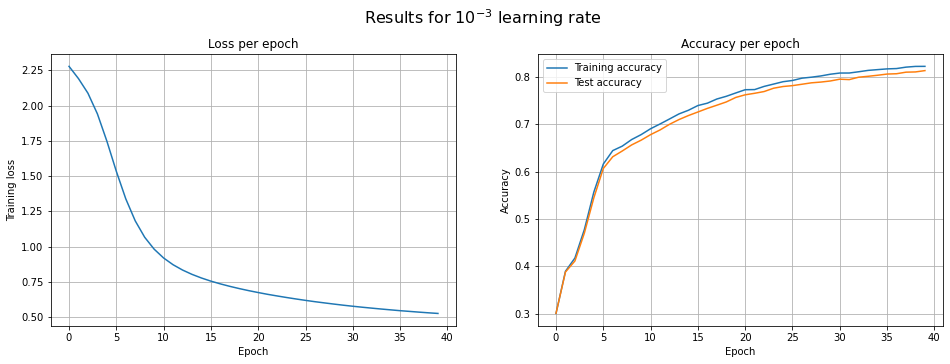

In [8]:
#plotting
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(40), loss_per_epoch)
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.arange(40), train_acc_per_epoch, label="Training accuracy")
plt.plot(np.arange(40), test_acc_per_epoch, label="Test accuracy")
plt.title("Accuracy per epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.suptitle("Results for $10^{-3}$ learning rate", fontsize=16, y=1.01)
print(f"End train accuracy: {train_acc_per_epoch[-1]}")
print(f"End test accuracy: {test_acc_per_epoch[-1]}")

For the `learning_rate` of $10^{-3},$ the model optimization results in a smoothly decreasing loss and accuracy values, when plotted as a function of the number of epochs. The train and test accuracies start off completely aligned, and don't separate by more than 1%. Hence there is no risk of overfitting. It is also promising that the accuracies increase over 60% after only 5 epochs. However, after 20 epochs, the improvements per epoch significantly slow down, and the maximum accuracies reached are around 82 and 81%, respectively. This performance, although not bad, is not ideal given the number of parameters we have, and the mathematical complexity of the model. From the fact that this model has no smoothness/oscillatory problems, I suspect that the optimal learning rate is bigger than $10^{-3}$. In the next section, we try and compare different learning rates.

<a name="q111"></a>

### 1.1.2 Exploration of the effect of the learning rate [^](#outline)
This section explores the dependence of the model results on the value of the learning rate of the stochastic gradient descent algorithm. This is relevant because SGD tend to be sensitive of the learning rate. This is increasingly true given that we have a lot of parameters, and thus the loss landscape may have a complicated geometry. We run the model for two additional values of $10^{-5}$ and $10^{-1}$ of the learning rate.

In [9]:
def run_MLP(epochs=40, learning_rate=1e-3):
    """Train and plot metrics of an MLP with a specified learning rate and number of epochs."""
    
    model = MLP(x_train_flat, y_train, x_test_flat, y_test)
    W, b, loss_per_epoch, train_acc_per_epoch, test_acc_per_epoch = model.SGD(epochs=epochs, learning_rate=learning_rate)
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(epochs), loss_per_epoch)
    plt.title("Loss per epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Training loss")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(epochs), train_acc_per_epoch, label="Training accuracy")
    plt.plot(np.arange(epochs), test_acc_per_epoch, label="Test accuracy")
    plt.title("Accuracy per epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()

    plt.suptitle(f'Results for learning rate {learning_rate}', fontsize=16, y=1.01)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [10:55<00:00, 16.39s/it]


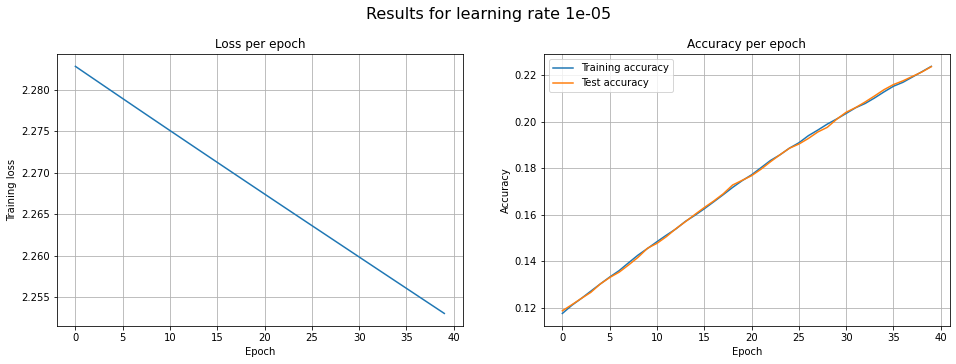

In [10]:
run_MLP(epochs=40, learning_rate=1e-5)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [22:42<00:00, 17.04s/it]


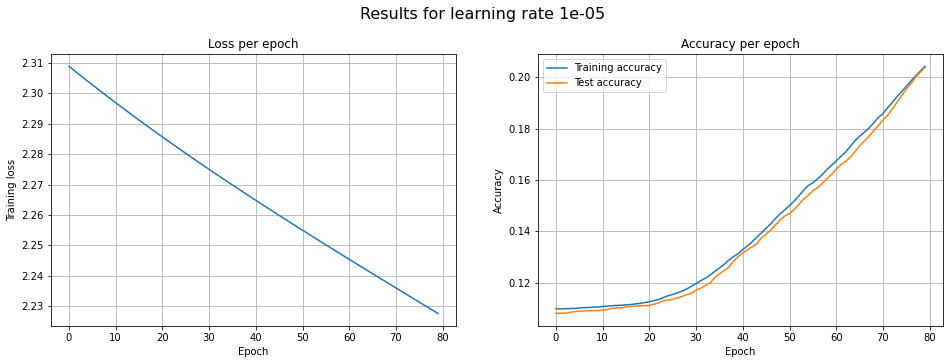

In [11]:
run_MLP(epochs=80, learning_rate=1e-5)

We see that the $10^{-5}$ `learning_rate` performs poorly on both the train and test dataset. Looking at the first pair of plots, we see that after 40 epochs, the peak accuracy is below around 22% for both, which is only 12% better than a completely random classifier. The reason might be that this learning rate slows down convergence and would need training for more epochs to achieve accuracy results comparable to that in section 1.1.1. The loss and train accuracy as functions of the epochs look close to linear, which supports the claim that after 40 epochs, the model is still in the very early stages of training. In fact, this is true even after 80 epochs, as shown above. The plots for 80 epochs also show the sensitivity of the model on the stochasticity of SGD. We see that after 80 epochs, the accuracy is still below the 22% that a previous run of the model reached after 40 epochs. We see that this learning rate is far from optimal (although the functions are very smooth).

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [11:44<00:00, 17.61s/it]


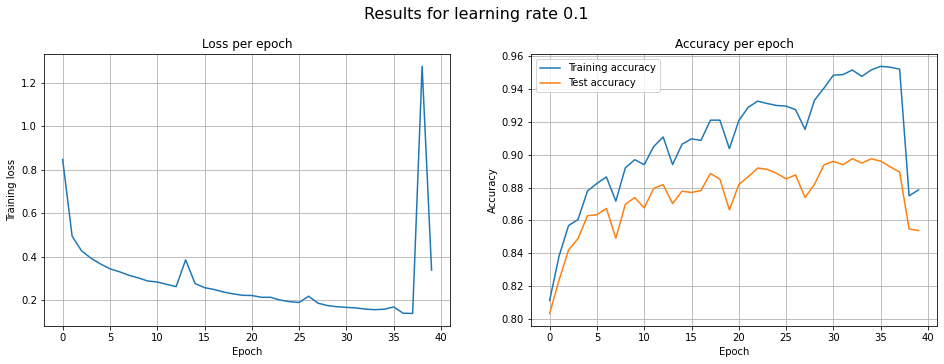

In [12]:
run_MLP(epochs=40, learning_rate=1e-1)

The $0.1$ `learning_rate` achieves high accuracies for both the training and test datasets. Most notably the peak accuracy is above 95% for the training dataset. However, the difference in the training and test set can be as high as 6%, which raises the suspicion of overfitting. We also observe significant oscillations of the accuracy.  Most prominently, we observe a dramatic drop in accuracy after the 35th epoch, which starts to get corrected in the last epochs. This is also shown in the training loss value a a sudden dramatic upwards jump. This (and some other more moderate) sudden changes indicate that the learning rate is too large, and thus the optimiser is oscillating around the optimal value. Although we have good overall convergence of the loss and accuracy, this method is not reliable, since the end performance can be heavily dependent on the exact number of training epochs and the stochasticity of the SGD. For example, if we have stopped training after 35 epochs, we would have reached much righer accuracies.

We have concluded that 0.1 is too large, $10^{-5}$ is too low and suspect that $10^{-3}$ may be too low. Hence, I have looked at the model performance with a learning rate of $0.01$. The resulting accuracies are good, however we already see small signs of the behaviour or the $10^{-1}$ model. The loss is relatively smooth, but the accuracies are showing oscillations, and a gap (of around 3%) between train and test accuracy starts forming. A more detailed grid search could be done, and the resulting optimal value is likely to be between $0.01$ and $10^{-3}$, probably closer to the latter. 

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [10:59<00:00, 16.48s/it]


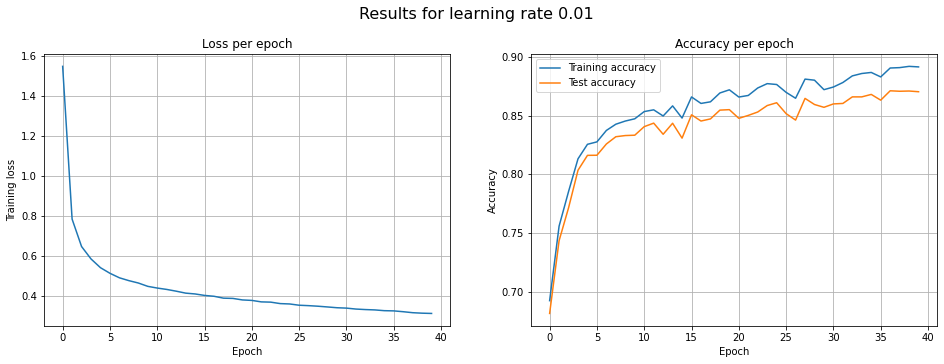

In [13]:
run_MLP(epochs=40, learning_rate=1e-2)

<a name="q113"></a>

### 1.1.3 Exploration of the effect of the number of epochs [^](#outline)

We now train the model in 1.1.1 for 80 epochs. This makes sense because the model with `learning_rate` $10^{-3}$ had good stability properties, but the convergence was slow. The plot below shows that by running the model for 80 epochs, we only get an increase of about 2-3% both in the train and test accuracies. After 40 epochs, convergence of the loss and the accuracies is slow, and hence the improvement is small. 

Longer training may effect some models better. We have seen that it, benefitted the model with `learning_rate`=$10^{-5}$ in the sense that when it was trained for 80 epochs, it improved around 7%. However, that models needs much longer training to even have the chance to reach comparable results (most probably it won't). The $10^{-1}$ model would have probably continued its oscillations had it been trained for 80 epochs. In general, longer training significantly benefits those models that are stable, and the rate of decrease in the loss (increase in the accuracies) has not yet reached a very low value yet.

Going back to out $10^{-3}$ model, we can conclude that its strengths are the lack of overfitting and stability. The weekness is the slow convergence above around 80% accuracy. In light of this, the goodness of the model depends on the goals it is used for. If close to perfect accuracy is a priority, then this model is not suitable.

In [14]:
model_80 = MLP(x_train_flat, y_train, x_test_flat, y_test)
W_80, b_80, loss_per_epoch_80, train_acc_per_epoch_80, test_acc_per_epoch_80 = model_80.SGD(epochs=80, learning_rate=1e-3)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [21:53<00:00, 16.42s/it]


40 epochs model
 end train accuracy=0.8224833333333333
 end test accuracy=0.8135
80 epochs model
 end train accuracy=0.8495
 end test accuracy=0.8379


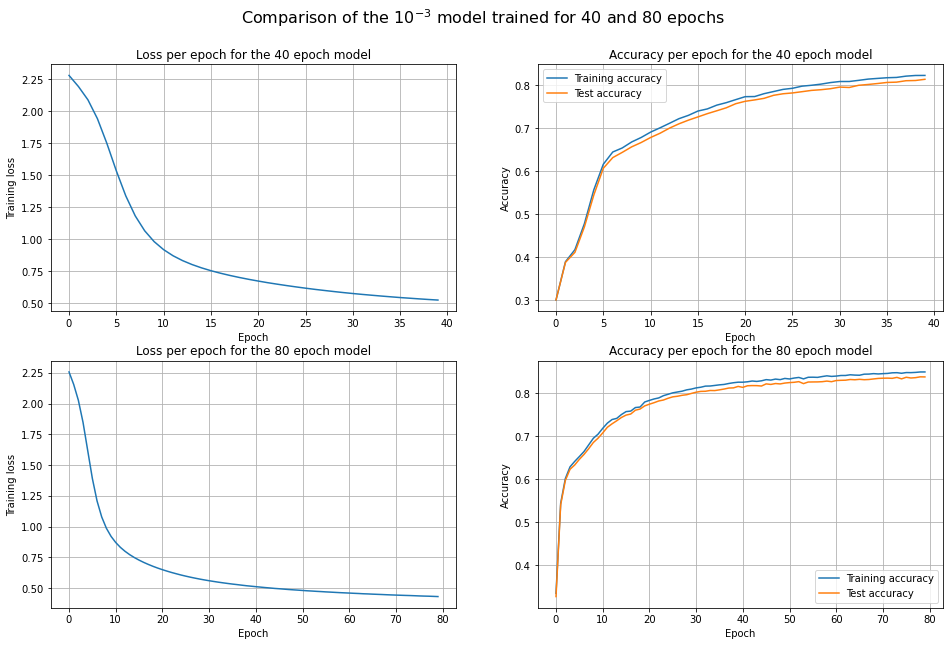

In [146]:
#plotting
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(np.arange(40), loss_per_epoch)
plt.title("Loss per epoch for the 40 epoch model")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(np.arange(40), train_acc_per_epoch, label="Training accuracy")
plt.plot(np.arange(40), test_acc_per_epoch, label="Test accuracy")
plt.title("Accuracy per epoch for the 40 epoch model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(np.arange(80), loss_per_epoch_80)
plt.title("Loss per epoch for the 80 epoch model")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(np.arange(80), train_acc_per_epoch_80, label="Training accuracy")
plt.plot(np.arange(80), test_acc_per_epoch_80, label="Test accuracy")
plt.title("Accuracy per epoch for the 80 epoch model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.suptitle("Comparison of the $10^{-3}$ model trained for 40 and 80 epochs", fontsize=16, y=0.96)

print(f"40 epochs model\n end train accuracy={train_acc_per_epoch[-1]}\n end test accuracy={test_acc_per_epoch[-1]}")
print(f"80 epochs model\n end train accuracy={train_acc_per_epoch_80[-1]}\n end test accuracy={test_acc_per_epoch_80[-1]}")

<a name="q12"></a>
## 1.2 Convolutional neural network (CNN) [^](#outline)

In practice, multi-layer perceptrons are rarely used for image recognition. For this task, convolutional neural networks (CNNs) are much better. CNNs are a scpecial case of the multilayer perceptron architecture, but it has a key property called translation equivariance. The translation equivariance property of CNNs ensures that the model (to some extent) recognizes that translations don't completely change an image, an inherent structure is preserved. Equivariant neural networks fall into the category of geometric deep learning. This area is concerned with data that has some underlying geometric relationships. The data can come from the surface of a sphere, from grids, groups, graphs or even gauges.

Normal CNNs are a bit less exotic. They use convolution filters that slide along input features and thus provide translation equivariant responses. These are known as feature maps. The architectural design of CNNs mimics the visual system in the body. There, neurons respond to stimulus in a restricted region of the visual field, just like the neurons of CNNs. This makes CNNs suitable for image recognition tasks, as we will see from below.

This section, we implement and evaluate a CNN model with specified architecture. We also explore the effects of dropout regularization, a technique used to prevent overfitting. We also touch on the topic of interpretability by exploring how the CNN learns features.

<a name="q121"></a>

### 1.2.1 Implementation [^](#outline)

Below we use tensorflow to implement the CNN model described in the task. We first convert our datasets to a tensorflow `Dataset` object, shuffle and batch it. The function `get_model` creates and compiles the model with the following architecture.
1. Intput layer
2. 4 convolutional layers of dimension 2
3. A 2 dimensional max pooling layer
4. A flatten layer needed to call the dense layer next
5. A dense layer
6. An output layer.

We train this model for 40 epochs using the same activations and optimisers as in Section 1.1.

In [16]:
# imports for CNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
import pydot_ng as pydot
pydot.find_graphviz()
import graphviz

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.shuffle(353)
train_dataset = train_dataset.batch(256)
train_dataset.element_spec

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(353)
test_dataset = test_dataset.batch(256)

In [18]:
def get_model():
    """Set up and compile a CNN model with the architecture specified in the task statement."""
    CNN_model = Sequential([
        InputLayer(input_shape=(28, 28, 1)),
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01)),    
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01)),
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),
        MaxPool2D((2, 2)),
        Flatten(),

        Dense(64, activation=LeakyReLU(alpha=0.01)),
        Dense(10, activation='softmax')
        
    ])
    CNN_model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])
    return CNN_model

In [19]:
CNN_model = get_model()
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                        

In [ ]:
# I could not run this cell locally, only on colab (which I lost access to). It plots the model summary interactively. 
# tf.keras.utils.plot_model(CNN_model, to_file='CNN_model.png', show_shapes=True, show_layer_names=True)

In [20]:
history_dropout = CNN_model.fit(train_dataset, batch_size=256, epochs=40, validation_data=test_dataset, verbose=False)

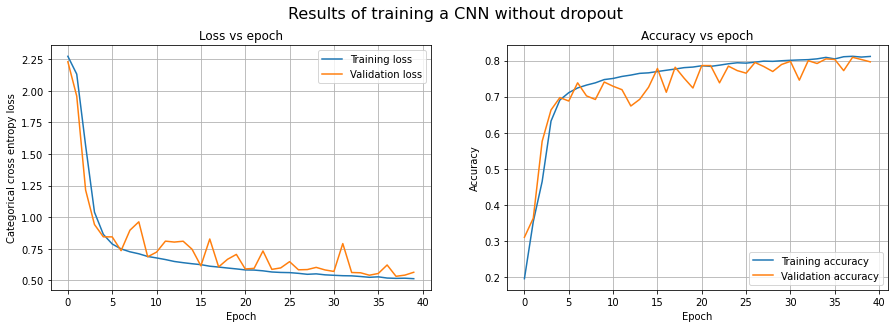

In [21]:
plt.figure(figsize=(15, 4.5))
plt.subplot(1, 2, 1)
plt.plot(history_dropout.history['loss'], label="Training loss")
plt.plot(history_dropout.history['val_loss'], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history_dropout.history['accuracy'], label="Training accuracy")
plt.plot(history_dropout.history['val_accuracy'], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs epoch")
plt.legend()
plt.grid()
plt.suptitle("Results of training a CNN without dropout", fontsize=16, y=1)
plt.show()

Comparing this plot to the one in 1.1.1, we see that the MLP and the CNN perform similarly in terms of training loss convergence and train/test accuracy. A difference is, however, the oscillations and gap in the CNN validation loss and accuracy, the latter potentially showing overfitting. This may be surprising given the fact that we expect CNN to be better in image classification. A first explanation might be that our dataset is too simple (for instance, our images only contain one object each, there is no translation, etc.) for the advantages of CNN to be visible.

We can also improve the CNN model by regularisation. In the next section, we incorporate Dropout regularisation in the model.

<a name="q122"></a>

### 1.2.2 Dropout regularisation [^](#outline)

The method of dropout was deveoped to prevent overfitting in neural networks. It randomly 'drops out' neurons in the network during training according to a Bernoulli mask whose values are independently sampled at every iteration. So it is correct to call dropout a regularizer, as it pushes some neurons to zero, and pushes others towards zero. This is because the capacity of the model will be reduced, and hence the neurons will not be able to co-adapt too much. This means that the neurons will not be able to depend on any other neurons in the network, which results in them learning more robust features. Thus the model will have better generalization abilities.

For our oscillatory CNN with signs of overfitting, we expect dropout to improve smoothness and decrease the train and validation accuracy gap. Since the dropout rate is a parameter, we train 10 models with dropout rates ranging linearly from $0.1$ to $0.9$ in order to find the optimal fropout rate. Naturally, we don't expect to get very high values of the dropout rate, as losing 90% of the neurons would result in a huge decrease in the accuracy. In order to evaluate the effect of dropout, we compare model performances, and the activations of the hidden units of the fully connected layer when the model is evaluated on the test set.

In [22]:
# preparing the data: split to train and validation sets
from sklearn.model_selection import train_test_split

#x_train = (x_train - x_train.mean()) / x_train.std()

train_data, val_data, train_targets, val_targets = train_test_split(x_train, y_train, test_size=0.2)
train_dataset_drop = tf.data.Dataset.from_tensor_slices((train_data, train_targets))
val_dataset_drop = tf.data.Dataset.from_tensor_slices((val_data, val_targets))

train_dataset_drop = train_dataset_drop.shuffle(353)
train_dataset_drop = train_dataset_drop.batch(256)
#train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
train_dataset_drop.element_spec

val_dataset_drop = val_dataset_drop.shuffle(353)
val_dataset_drop = val_dataset_drop.batch(256)

In [23]:
def get_dropout_model(dropout_rate):
    """Set up and compile a CNN model with a dropout layer added after the dense layer."""
    CNN_dropout_model = Sequential([
        InputLayer(input_shape=(28, 28, 1)),
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01)),    
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01)),
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),
        MaxPool2D((2, 2)),
        Flatten(),

        Dense(64, activation=LeakyReLU(alpha=0.01)),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')

    ])
    CNN_dropout_model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])
    return CNN_dropout_model

In [24]:
def CNN_cross_val(dropout_range):
    """Compare validation accuracy of CNNs with different dropout rate hyperparameters."""
    best_val_accuracy = 0
    accuracies = []
    best_rate = None
    for rate in tqdm(dropout_range):       
        CNN_dropout_model = get_dropout_model(rate)
        val_accuracy = CNN_dropout_model.fit(train_dataset_drop, batch_size=256, epochs=40, validation_data=val_dataset_drop, verbose=False).history['val_accuracy'][-1]
        accuracies.append(val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_rate = rate
    return best_rate, best_val_accuracy, accuracies

In [25]:
best_rate, best_val_accuracy, accuracies = CNN_cross_val(np.linspace(0.1, 0.9, 9))

100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [2:31:22<00:00, 1009.18s/it]


The optimal dropout rate is: 0.2
Dropout accuracies: [0.8019999861717224, 0.8026666641235352, 0.7846666574478149, 0.7741666436195374, 0.7791666388511658, 0.7603333592414856, 0.7545833587646484, 0.7439166903495789, 0.7117499709129333]


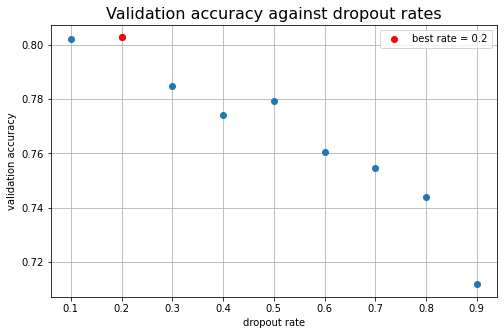

In [105]:
print(f"The optimal dropout rate is: {best_rate}")
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0.1, 0.9, len(accuracies)), accuracies, 'o')
plt.plot(best_rate, accuracies[np.where(np.linspace(0.1, 0.9, len(accuracies))==best_rate)[0][0]], 
         'ro', label=f"best rate = {best_rate}")
plt.xlabel("dropout rate")
plt.ylabel("validation accuracy")
plt.title("Validation accuracy against dropout rates", fontsize=16)
plt.legend()
plt.grid()
print(f"Dropout accuracies: {accuracies}")

In [27]:
CNN_model_optimal = get_dropout_model(best_rate)
history_opt = CNN_model_optimal.fit(train_dataset_drop, batch_size=256, epochs=40, validation_data=test_dataset, verbose=False)

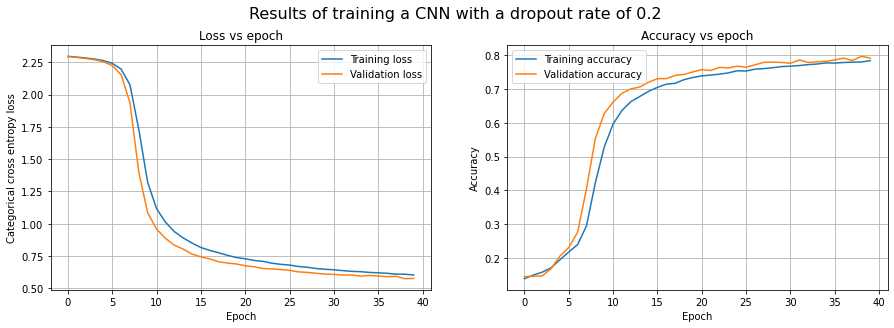

In [28]:
plt.figure(figsize=(15, 4.5))
plt.subplot(1, 2, 1)
plt.plot(history_opt.history['loss'], label="Training loss")
plt.plot(history_opt.history['val_loss'], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history_opt.history['accuracy'], label="Training accuracy")
plt.plot(history_opt.history['val_accuracy'], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs epoch")
plt.legend()
plt.grid()
plt.suptitle(f"Results of training a CNN with a dropout rate of {best_rate}", fontsize=16, y=1)
plt.show()

We see that the dropout regularization has reduced the oscillations in the convergence, and the (small) training and validation accuracy gap has in fact changed for the favour of the validation dataset. Thus the regularized model did not overfit to the train data. The optimal rate of the dropout regularization was $0.2$, where the grid search was showing a not-so-clear peak. I should note that previous runs of the model showed a peak at $0.1$ and $0.4$ as well. As expected, we see that high dropout rates decrease the validation accuracy. However, it was interesting to observe that the $0.9$ dropout rate still resulted in an accuracy of 71%. This raises the question of our model being overparametrised. In particular, the dense layer has more than 100000 parameters giving over 95% of the model parameters. Our search for the optimal dropout has shown that effectively, 20% of these (and in some runs of the model, even 40%) could be excluded after the dense layer. Of course, the dropped out neurons are still part of the training and hence are parameters of the dropout model. 

Next, we wish to visualize the regularization employed by the dropout layer. We look at the post activations of the hidden units in the fully connected layer (after dropout). We plot histograms of all the activations, as well as the mean activations taken over a subset of the data. We expect that with dropout, fewer units have high activation than without dropout. This means that we expect that dropout will push many units towards activation 0. For this, we take a random mini batch out of the test dataset. To get the activations, we build a shorter model that is a truncation of our original model, up to the end on the dropout layer. This will enable us to extract the activations by feeding the mini batch into `model.predict`.

In [29]:
# create mini batch for both x and y
np.random.seed(2022)
mini_batch_ind = np.random.choice(10000, 256, replace=False)
x_test_mini_batch = np.expand_dims(x_test[mini_batch_ind], axis=0)
y_test_mini_batch = np.expand_dims(y_test[mini_batch_ind], axis=0)
batch_dataset = tf.data.Dataset.from_tensor_slices((x_test_mini_batch, y_test_mini_batch))

In [181]:
# create truncated model for no-dropout model
layer_outputs = [layer.output for layer in  CNN_model.layers[:-1]]
activation_model = Model(inputs=CNN_model.input, outputs=layer_outputs, name="truncated_no_dropout")
activation_model.summary()
activations = activation_model.predict(batch_dataset)

# create truncated model for dropout model
layer_outputs_dropout = [layer.output for layer in  CNN_model_optimal.layers[:-1]]
activation_model_dropout = Model(inputs=CNN_model_optimal.input, outputs=layer_outputs_dropout, name="truncated_dropout")
activation_model_dropout.summary()
activations_dropout = activation_model_dropout.predict(batch_dataset)

Model: "truncated_no_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                              

In [180]:
# check that shapes are correct - should be 256 x 64 as dense layer has 64 units
print(f"Shape of activations: {activations[-1].shape}")
print(f"Shape of activations (dropout): {activations_dropout[-1].shape}")

Shape of activations: (256, 64)
Shape of activations (dropout): (256, 64)


In [177]:
# compute mean activations across the mini batch for both models
mean_activations = np.mean(activations[-1], axis=0)
mean_activations_dropout = np.mean(activations_dropout[-1], axis=0)
flat_activations = activations[-1].reshape(256*64) 
flat_activations_dropout = activations_dropout[-1].reshape(256*64) 

Overall mean activations for model without dropout: 2.7885966300964355
Overall mean activations for model with dropout: 0.7909915447235107


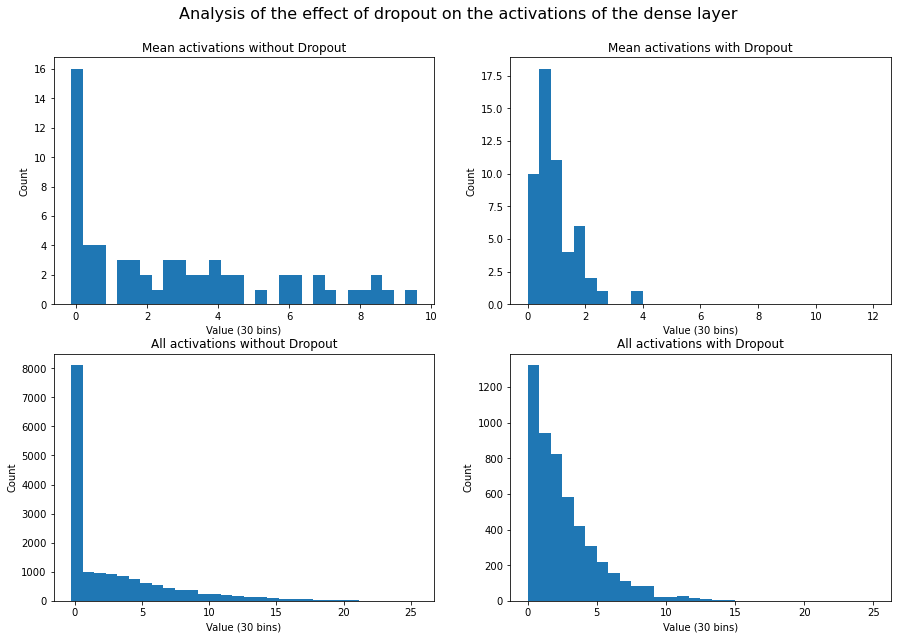

In [149]:
#plotting
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist(mean_activations, bins=30)
plt.xlabel("Value (30 bins)")
plt.ylabel("Count")
plt.title("Mean activations without Dropout")
plt.subplot(2, 2, 2)
plt.hist(mean_activations_dropout, range=(0, 12), bins=30)
plt.xlabel("Value (30 bins)")
plt.ylabel("Count")
plt.title("Mean activations with Dropout")

plt.subplot(2, 2, 3)
plt.hist(flat_activations, bins=30)
plt.xlabel("Value (30 bins)")
plt.ylabel("Count")
plt.title("All activations without Dropout")
plt.subplot(2, 2, 4)
plt.hist(flat_activations_dropout, range=(0, 25), bins=30)
plt.xlabel("Value (30 bins)")
plt.ylabel("Count")
plt.title("All activations with Dropout")
plt.suptitle("Analysis of the effect of dropout on the activations of the dense layer", fontsize=16, y=0.95)

# this is the same as the mean of the flat activations
print(f"Overall mean activations for model without dropout: {np.mean(mean_activations)}")
print(f"Overall mean activations for model with dropout: {np.mean(mean_activations_dropout)}")

We see on the histograms that the activations of the hidden units become smaller when using dropout, even though we have not used any sparsity inducing regularizer. Indeed, in the dropout model, we have no above 4. The model with dropout has a more units with high activations, in particular the overall mean activation is larger. This is in accordance with what we have expected from dropout, and is also in accordance with what we have seen on the loss and accuracy plots. The sparser activations result in less oscillation and better convergence, because there are very few units with very high activations. Dropout also mitigates overfitting, because it does not give high activations to neurons and thus these don't learn deatures that are too specific to the training data.

<a name="q123"></a>

### 1.2.3 Comparison to MLP [^](#outline)

The table below compares the performance of the two CNN models and the Multi-layer perceptron. We see that the MLP has more than 9 times as many parameters as the CNN models. However, the CNN is more complex mathematically. Although the mathematical complexity of a model can be a drawback, CNN is really a special case of the MLP designed to work well on images, so this is not an issue. The resulting accuracies are very comparable, the MLP being slightly better than the CNNs. Based on this, I would favour the CNN. If it is possible to achieve similar results with significantly fewer parameters, then by Occam's razor, one should not favour an overparametrised model. If the accuracy was crucial, one could add more layers and a more sophisticated architecture to the CNN which would probably achieve much higher accuracies. 

One should take into account the wall-clock training times of the models. I have ran both the MLP and CNN on the CPU.The MLP took around 9-9:30 minutes for 40 epochs, the CNN and around 13-14, which is more than 30% more. We should note that training on GPUs can significantly fasten both processes. In theory, however, CNN-s are more computationally intensive, because the layers perform more complex tasks. On the other hand, MLPs instead more parameters. We thus have a tradeoff between the models, where different models may be ideal for different data and model design goals. As we have noted above, our dataset contains very simple images of low resolution. This setting does not let the strengths of CNN (doesn't require flattening until the dense layer, translational invariance, etc.) properly manifest, which is why we achieved very comparable performance with the MLP.

One should take into account the wall-clock training times of the models. I have ran both the MLP and CNN on my computer's CPU and on Google Colab.The MLP took around 10 minutes for 40 epochs locally and around 15 on Google Colab. The CNN took around 16-17 mins locally, which is more than 60% more that the running time of the MLP. I have then run the CNN models on Google Colab's GPU, which took around 3 minutes per model. Then final run of the models was done on my CPU. (I do not include running times in the table below, because my implementations and computational resources are clearly not optimal, hence it would not be a fair comparison. I only included the numbers here for reference.) 

In theory, however, CNN-s are more computationally intensive, because the layers perform more complex tasks. On the other hand, MLPs have more parameters. (Calculation for the MLP was done by adding up the areas of the layers as this is the total number of parameters. The CNN models displayed the number of parameters. I have also calculated the number of parameters remaining in the CNN after dropout. Note that the excluded parameters still play a role in the training). We thus have a tradeoff between the models, where different models may be ideal for different data and model design goals. As we have noted above, our dataset contains very simple images of low resolution. This setting does not let the strengths of CNN (doesn't require flattening until the dense layer, translational invariance, etc.) properly manifest, which is why we achieved very comparable performance with the MLP.

In [113]:
params = np.array(['957600', '107266', '107266 trained, 86773 after dropout'])
train_acc = np.array([train_acc_per_epoch[-1], history_dropout.history["accuracy"][-1], history_opt.history["accuracy"][-1]])
test_acc = np.array([test_acc_per_epoch[-1], history_dropout.history["val_accuracy"][-1], history_opt.history["val_accuracy"][-1]])
mlp_CNN_df = pd.DataFrame(np.array([params, train_acc, test_acc]),
                          columns=np.array(["Multi layer perceptron", "CNN without dropout", "CNN with dropout"]),
                          index=np.array(["Number of parameters", "Training accuracy", "Test accuracy"]))
mlp_CNN_df

,Multi layer perceptron,CNN without dropout,CNN with dropout
Number of parameters,957600,107266,"107266 trained, 86773 after dropout"
Training accuracy,0.8224833333333333,0.8112999796867371,0.7829375267028809
Test accuracy,0.8135,0.7962999939918518,0.7904000282287598


<a name="q124"></a>

### 1.2.4 Feature maps [^](#outline)
The loss of interpretability is a key concern in deep learning models. In this section, we aim to understand how our CNN model learns, in particular, what features are extracted by each of the convolutional layers.
To get the activations, as before we build a shorter model that is a truncation of our original model, up to the end on the convolutional layers. This will again enable us to extract the activations by feeding a chosen image into `model.predict`.

shape of one image: (1, 28, 28)
Label of image: Pullover


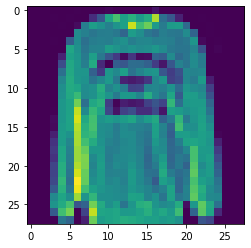

In [34]:
# choose an image
test_img = np.expand_dims(x_test[1606], axis=0)
print(f"shape of one image: {test_img.shape}")
plt.imshow(x_test[1606])

label_dict = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
              6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
print(f'Label of image: {label_dict[np.where(y_test[1606]==1)[0][0]]}')

In [35]:
# obtain the activations, check we have all 4 Conv2D layers
layer_outputs = [layer.output for layer in  CNN_model_optimal.layers[:5]]
activation_model = Model(inputs=CNN_model_optimal.input, outputs=layer_outputs)
activation_model.summary()
activations = activation_model.predict(test_img)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 26, 26, 8)         80        
                                                                 
 conv2d_41 (Conv2D)          (None, 24, 24, 8)         584       
                                                                 
 conv2d_42 (Conv2D)          (None, 22, 22, 16)        1168      
                                                                 
 conv2d_43 (Conv2D)          (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 16)       0         
 g2D)                                                            
                                                             

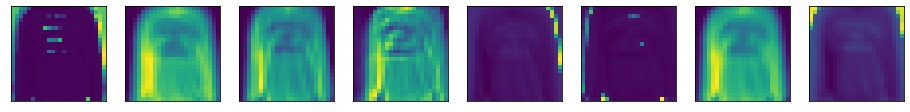

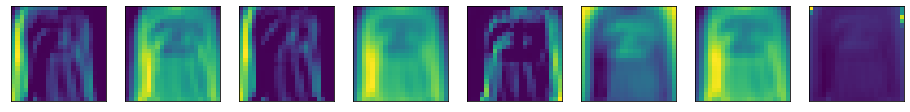

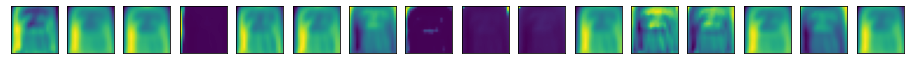

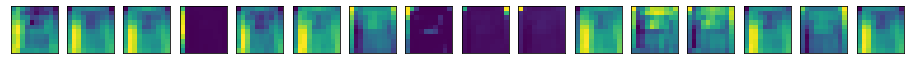

In [128]:
# plotting all the feature maps across the 4 Conv2D layers
rows, columns = 1, 8

for ftr in activations[1:3]:
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns*rows + 1):
        fig = plt.subplot(rows, columns, i)
        fig.set_xticks([])
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='viridis')
    plt.show()

rows, columns = 1, 16
for ftr in activations[3:]:
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns*rows + 1):
        fig = plt.subplot(rows, columns, i)
        fig.set_xticks([])
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='viridis')
    plt.show()

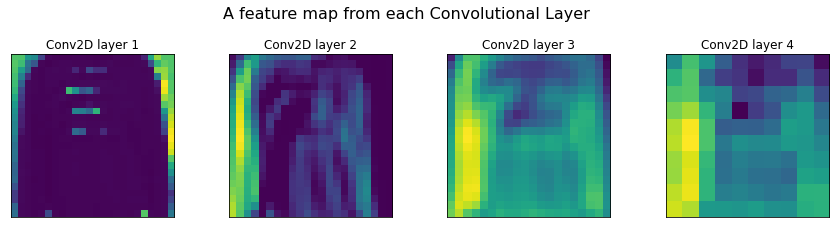

In [131]:
# plotting the last column only
i=1
fig = plt.figure(figsize=(15, 3))
for ftr in activations[1:]:
    fig = plt.subplot(1, 4, i)
    fig.set_title(f"Conv2D layer {i}")
    fig.set_xticks([])
    fig.set_yticks([])
    i+=1
    plt.imshow(ftr[0, :, :, 0], cmap='viridis')
plt.suptitle("A feature map from each Convolutional Layer", fontsize=16, y=1.1)
plt.show()

The above two plots show the feature maps extracted by each of the convolutional layers. In the first plot, the feature maps are plotted in the direction of decreasing depth, that is, the first row corresponds to the first (deepest) convolutional layer. Note that layers 1 and 2 have 8, 3 and 4 have 16 feature maps. On plot 2, we look at the first feature map of each layer. The lighter the colour of the pixel, the higher the ativation is of the corresponding node. We see that layer 1 seems to be looking for simple information: the background of the image. Since the horizontal 'stripes' on the pullover are dark, it interprets them as part of the background. So the first feature map highlights the contour of the shape. The feature map of the second layer highlights the edges on the image. By this time it seems to learn that the horizontal stripes are not part of the background. For the third one, an obvious interpretation is harder to find as the features it is looking for become more complicated. I think that (among other features) it looks for sleeves, as you can see a bringht red/green contour for the borders of the sleeves. The fourth feature map looks like an abstract painting, where a lot of information is condensed down to a very simple presentation. The features become more complex, and the output is (to me) not interpretable. 

Of course it is hard to interpret these images, and these explanations work only on an intuitive level. What we mean when we say an algorithm 'learns' is a very delicate notion as it is only a projection of what we think happens in our human mind when we ourselves obtain the results. However, it may not be that every stage of the algorithm maps to a stage in our mind that we are aware of. Human perception and intuition is a very complicated process, and it is too ambitious to believe that it can fully be described in such simple terms as weights and biases.

<a name="task-2"></a>

# Task 2: Unsupervised learning [^](#outline)

After exploring neural networks, we turn to the realm of unsupervised (and semi-supervised) learning. This means a change in perspective: instead of training a model with continuous comparison to labels, we now investigate cases when either no ground truth is known or exists, or we simply wish to not use this information. This setting of unsupervised learning means that we aim to explore the structure and relationships within the data and without any external information (labels). This is considered as a harder task, and especially the evaluation of results is challenging. Semi-supervised learning is a mix of the two strategies, where we make use of the unsupervised method first to then develop efficient supervised algorithms, that use the data more optimally (say in a compressed form). 

In this task, we make use of both unsupervised and semi-supervised learning methods to understand the Fashion-MNIST image dataset better, as well as to explore notions of dimensionality reduction, clustering, and the community structure of a population of dolphins.

<a name="q21"></a>

## 2.1 Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data [^](#outline)

Dimensionality reduction and clustering are the two major topics of unsupervised learning. The first methos aims to find a good representation of a dataset in lower dimension. If the original dimension $p$ of the data is very large, reducing it to $k \ll p$ dimensions can provide a more concise and interpretable description. Indeed, this way we only keep those variables that capture the properties of the data set. Clustering, on the other hand, aims to determine groups for the data points such that the samples within a group are more similar to each other than to other elements. Clustering can help interpret the data as a collection of groups, and motivate the investigation of what the groups mean.

In this section, we will implement algorithms for both dimensionality reduction and clustering. We will continue to be using (a subset of) the Fashion MNIST data and utilize a semi-supervised perspective to understand the methods more.

<a name="q211"></a>
### 2.1.1 Implementation of Principal Component Analysis (PCA) [^](#outline)

In the PCA algorithm, given the data
$$\{ x^{(i)} \}_{i=1}^N, \quad x^{(i)} \in \mathbb{R}^p,$$
we wish to approximate $x^{(i)}$ by
$$x_k^{(i)} = \sum_{j=1}^k a_j^{(i)} \phi_j + \sum_{i=k+1}^p b_j \phi_j,$$

where the $b_j$ are not dependent on $i$, hence are the same for all samples. After minimizing the mean square error as our error function, we obtain the optional MSE as
$$\text{MSE} =\sum_{j=k+1}^p \phi_j^{\star^T} C_x \phi^{\star}_j = \sum_{j=k+1}^p \phi_j^{\star^T} \lambda_j \phi^{\star}_j= \sum_{j=k+1}^p \lambda_j,$$
where $C_x$ is the covariance matrix of data $X$, $\lambda_j$  and $\phi^{\star}_j$ are the $k$ largest eigenvalues of $C_x$ and their corresponding eigenvectors. The eigenvectors are called the principal components. The sum of the remaining eigenvalues is also referred to as the total variance not explained by the first $k$ principal components.

We obtain the following approximation of our data
$$\hat{x}^{(i)} = \sum_{j=1}^k \left(x^{(i)^T} \cdot \phi_j^{\star} \right) \phi_j^{\star}.$$

When implementing PCA, we first need to normalize the data. We also check that the first 1000 values of the Fashion MNIST dataset form a more-or less balanced dataset. This is important because it confirms that we do not have to deal with mitigating inbalancedness in the data. We implement PCA in `pca_function`. We will make use of the `scipy.sparse.linalg.eigsh` function when computing the eigenvectors and values.

In [38]:
# imports for PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scipy as sc
from scipy.sparse import linalg

New shape: (1000, 784)


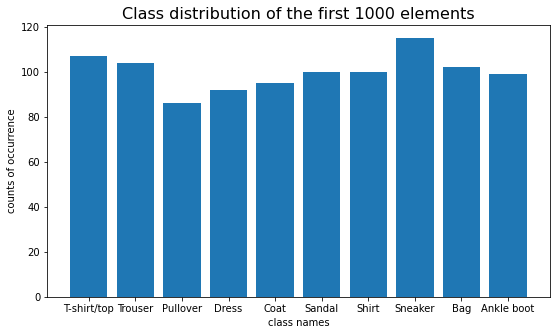

In [39]:
# Preprocessing of the data

# we take the first 1000 images
n_datapoints = 1000

# reshaping and taking a slice of the data
X = (x_train.reshape(-1, 28 * 28)[:n_datapoints]) / 255.
print(f"New shape: {X.shape}")

def standardise(X):
    """Standardise the data X."""
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

X = standardise(X)

# check that data is more-or less balanced
label_indices = np.array([np.where(y_train[:1000][i]==1)[0][0].tolist() for i in range(1000)])
label_dict = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
              6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

labels, counts = np.unique(label_indices, return_counts=True)
label_names = [label_dict[i] for i in labels]
labels = labels + np.ones(10)
plt.figure(figsize=(9, 5))
plt.bar(labels, counts, align='center')
plt.xlabel("class names")
plt.ylabel("counts of occurrence")
plt.title("Class distribution of the first 1000 elements", fontsize=16, y=1)
plt.gca().set_xticks(labels)
plt.gca().set_xticklabels(label_names)
plt.show()

In [40]:
def pca_function(X, k):
    """Perform PCA on the given dataset.
    
    Inputs:
        X (ndarray): (N, p)-shaped input data, on which we perform dimensionality reduction
        k (int): the number of first principal components 
                 (corresponding to largest in magnitude eigenvalues) to be returned
    
    Returns:
        X_pca (ndarray): (N, k)-shaped reduced representation of the data X
        eigenvectors (ndarray): shape (p, k), contains the eigenvectors of the covariance matrix
        eigenvalues (ndarray): shape (k,), contains the eigenvalues corresponding to the k eigenvectors
    """

    # create covariance matrix S
    C = 1.0/(len(X)-1) * np.dot(X.T, X)


    # compute largest k eigenvalues and eigenvectors
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

In [41]:
k = 25

# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,k) 
# check eigenvalues are in decreasing order
eigenvalues

array([175.6608   , 111.62358  ,  43.496704 ,  41.18451  ,  31.487623 ,
        25.32376  ,  21.559616 ,  19.177746 ,  13.931766 ,  11.404521 ,
         9.759378 ,   8.921607 ,   8.482842 ,   7.3857665,   6.8686643,
         6.299778 ,   5.3403516,   5.109607 ,   4.9962373,   4.8422494,
         4.4946074,   4.385231 ,   4.141935 ,   3.9076095,   3.693013 ],
      dtype=float32)

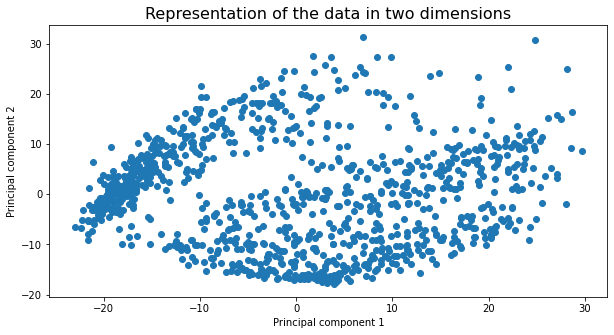

In [42]:
# visualize data in the first two components
plt.figure(figsize=(10, 5))
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("Representation of the data in two dimensions", fontsize=16, y=1)
plt.show()

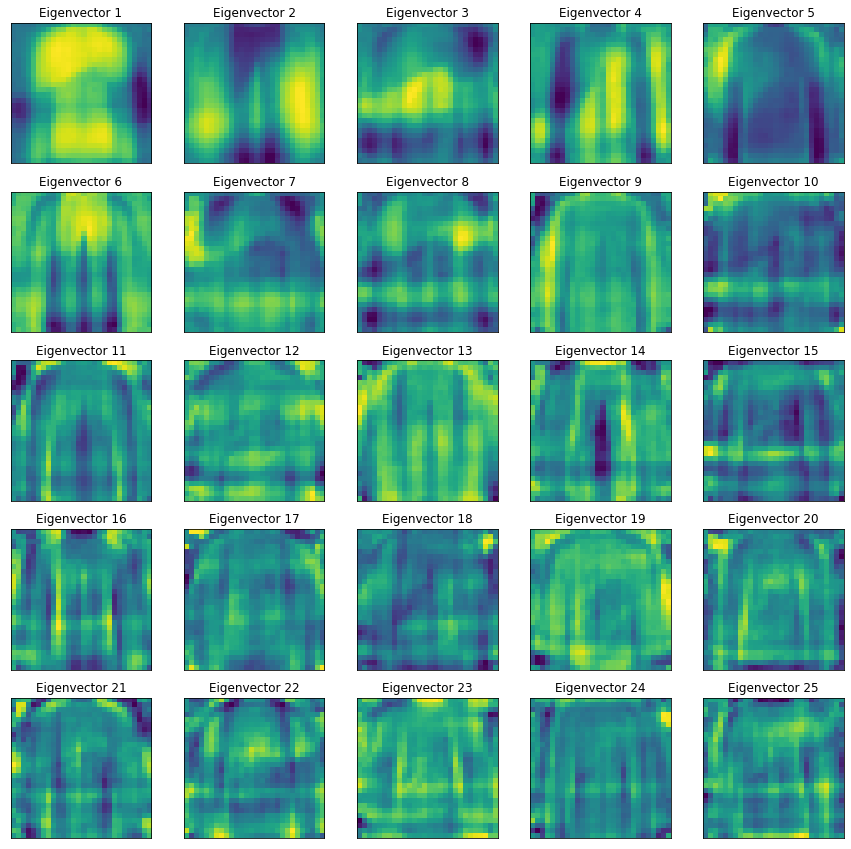

In [43]:
# plot all eigenvectors reshaped to image size
nrow = 5; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,15))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_title(f"Eigenvector {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

We see that the earlier eigenvectors seem to contain the most structure. This is in accordance with the fact that the first few principal components explain most of the variance in the data.

<a name="q212"></a>

### 2.1.2 Finding the optimal number of principal components [^](#outline)

Finding the number of principal components to optimally represent the data depends on the goals of the data analysis. In the cases where the data needs to be visualized in order to extract insights, we need to go with 2 or 3 principal components. Below, we plot the proportion of total variance explained by each of the components. In these plots, we look for a natural separation, 'drop' in the values after the ideal $k$. On the two leftmost figures, we see that the values (of the eigenvectors and of the explained variance) drop after the first and second principal components, indicating that these two are much more important than the other components. Indeed, on the rightmost plot, we see that these two components explain over 35% of the total variance in the data. However, as these are very few components, I would add a few more to increase accuracy. The two leftmost plots show a very slight drop after 4 components. These four components explain around 47-48% of the total variance. Thus, unless any constraint is placed on this latter value, $k=4$ would be the most natural value for $k$. If the accuracy is very important, one should select a higher number of components to meet the required threshold.

In [44]:
# correlation matrix
C = 1.0/(len(X)-1) * np.dot(X.T, X)
# need to find all eigenvalues, not only the first 25
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

explained_variances = eigenvalues /  total_variance
print('The explained variance for the first 25 principle components is:\n {}'.format(explained_variances))

The explained variance for the first 25 principle components is:
 [0.22469287 0.14278099 0.05563791 0.05268031 0.04027674 0.03239236
 0.02757754 0.02453082 0.01782053 0.01458786 0.01248351 0.01141189
 0.01085065 0.00944735 0.00878591 0.00805823 0.006831   0.00653585
 0.00639083 0.00619386 0.00574918 0.00560928 0.00529807 0.00499834
 0.00472384]


Text(0.5, 1, 'Results of the Principal Component Analysis')

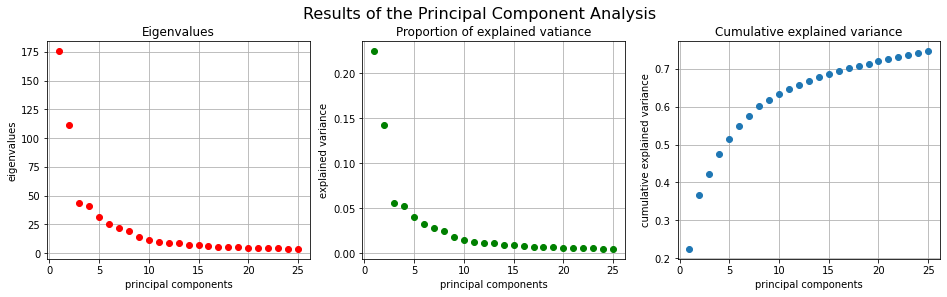

In [45]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(np.linspace(1, 25, 25), eigenvalues, 'o', color ='r')
plt.xlabel("principal components")
plt.ylabel("eigenvalues")
plt.title("Eigenvalues")
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(np.linspace(1, 25, 25), explained_variances, 'o', color='g')
plt.xlabel("principal components")
plt.ylabel("explained variance")
plt.title("Proportion of explained vatiance")
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(np.linspace(1, 25, 25), np.cumsum(explained_variances), 'o')
plt.xlabel("principal components")
plt.ylabel("cumulative explained variance")
plt.title("Cumulative explained variance")
plt.grid()
plt.suptitle("Results of the Principal Component Analysis", fontsize=16, y=1)

<a name="q213"></a>
### 2.1.3 Representing the data in two dimensions [^](#outline)

In this section, we take the first two principal components and visualize the data together with its labels. This can be useful because in some cases, dimensionality reduction reveals a clear cluster structure for the data, implying a prediction for the unknown labels. Our situation is different because we do have the labels and hence can visualize whether the clustering structure implied by the data point's position in two dimension aligns well with the distribution of the true labels.

Below we plot the data in the space of the first two principal components (see plot to the left) and also in the space of the second and sixth component (to the right). The reason for this latter plot is to show the differences in the clustering structure. We can see from both plots that points in the same class tend to cluster together, but we have long-shaped, overlapping clusters. Without the colours, only three clusters would be visible. Long-shaped clusters are especially hard to find via clustering algorithms, since these usually look for rounder, circle-like clusters (when there is no apparent cluster structure). Interestingly, the plot to the right distinctly clusters away class of Trousers and most of the class of Dresses, but the other clusters are even more overlapping. This shows that sometimes multiple visualizations minght be useful. For instance, if we were to predict the labels without knowing them, we could use the right-hand plot to identify the class two (that we know corresponds to trousers), then show it on the left-hand plot to check that it still looks like a cluster. Then one could remove these datapoints and cluster the remaining ones by subsequently finding views that distingtly cluster away some points, then validate again on the main plot.

Text(0.5, 1, 'Different visualizations of the data in dimension 2')

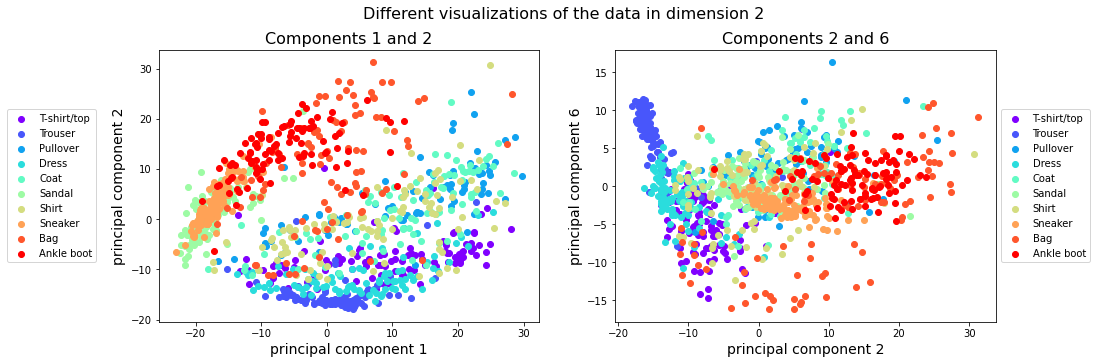

In [132]:
label_indices = np.array([np.where(y_train[:1000][i]==1)[0][0].tolist() for i in range(1000)])
colors_list_r =cm.rainbow(np.linspace(0,1, 10))

clusters = [np.where(label_indices==i)[0] for i in range(10)]
count = 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i, j, k in zip(clusters, colors_list_r, label_names):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], color=j, label=k)
    plt.legend(loc='center right', bbox_to_anchor=(-0.15, 0.5))
    plt.xlabel("principal component 1", fontsize=14)
    plt.ylabel("principal component 2", fontsize=14)
    
    plt.title("Components 1 and 2", fontsize=16, y=1)
    count += 1
plt.subplot(1, 2, 2)
count = 1
for i, j, k in zip(clusters, colors_list_r, label_names):
    plt.scatter(X_pca[i, 1], X_pca[i, 5], color=j, label=k)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("principal component 2", fontsize=14)
    plt.ylabel("principal component 6", fontsize=14)
    plt.title("Components 2 and 6", fontsize=16, y=1)
    count += 1
plt.suptitle("Different visualizations of the data in dimension 2", fontsize=16, y=1)

<a name="q214"></a>

### 2.1.4 Clustering the two dimensional data [^](#outline)

As mentioned above, the objective of clustering is to find a partition of the data samples into $k$ clusters such that that the dissimilarity is smaller within clusters than across clusters. There are various measures of similarity/dissimilarity, and these include distance measures. The k-means algorithm requires $k$ to be specified beforehand. Then the steps of the algorithm are:
1. Assign each data point to a cluster randomly
2. Compute the centroid for each cluster
3. Assign each data point to the cluster whose centroid it is closest to.
4. Repeat steps 2 and 3 until the value of the within-distance does not change by much (or until the maximum iteration has been reached)

In this section, we cluster the datapoints in the space of the first two principal components. Frist, we implement the k-means clustering algorithm in the function `k-means`, and apply it on our approximated data by varying the value of $k$ between 2 and 10. The plots show that k-means is very ill-suited for our problem. Without the labels, the data points show two long-shaped clusters. From the labels we know that these contain 10 overlapping clusters of a roughly similar shape. k-means even fails to separate the two 'visible clusters' well-enough. For $k>2$ there is no visible clustering structure, and we can see that as k increases, k-means adds roughly circular-shaped clusters. For the ground truth $k=10$, k-means gives a very artificial, map-looking clustering. This is because of the symmetry of the k-means algortihm. The idea of circular-shaped clusters makes sense in general, but is completely unsuitable for our data, that has long-shaped clusters. 

One could construct a metric to evaluate the clustering results based on the true labels. A possible strategy is the elbow method. This uses the within distance as metric $W(C)$ (for clustering $C$), which needs to be plotted to identify the 'elbow' on the plot. Roughly, is the smallest $k$ that produces a small $W$. The plot of the within distances for each clustering has elbows at $k=3, 4$. However, we see that all of the clusterings are terrible. The least bad one is probably $k=2$, since it manages to capture some of the idea of the long-shaped clusters. If I were to pick an optimal $k$ without the knowledge of the labels, I would pick $k=2$ unless I had external knowledge on the data implying that $k=2$ being infeasible. In this case I would pick $k=4$, as it looks slightly more natural to me than the plot for $k=3$. 

In [47]:
def k_means(X_pca, k, max_iter):
    """Cluster the data points into k clusters using the k-means algorithm.
    
    Inputs:
        X_pca (ndarray): (N, 2)-shaped reduced representation of the data X
        k (int): number of clusters to be found
        max_iter (int): number of iterations after which the process terminates.
    
    Returns:
        comp1 (ndarray): vector of shape (N,) first principal component of the data
        comp2: (ndarray): vector of shape (N,) second principal component of the data
        labels (list): of length N, gives the cluster number for each data point
        centroids (ndarray): shape (k, 2) containing the coordinates of the centroid for each cluster
    """
    n_features=2
    n_samples=1000
    labels = np.random.randint(low=0, high=k, size=n_samples)
    centroids = np.zeros((k, n_features))
    X = np.array(list(zip(X_pca[:,0], X_pca[:,1])))
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:2]

    new_labels = np.zeros(len(X_pca))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        #print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            #print(f'Labels unchanged! Terminating k-means at iteration {i}.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            #print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    comp1 = X_pca[:,0]
    comp2 = X_pca[:,1]
    
    # within distance
    distances_final = np.array([np.linalg.norm(X - c, axis=1) for c in centroids]).T
    cluster_indices = [np.where(labels==i)[0] for i in range(k)]

    W = np.sum([np.sum(distances_final[cluster_indices[i], i]) for i in range(len(cluster_indices))])
    return comp1, comp2, labels, centroids, W

Text(0.5, 0.94, 'Results of k-means clustering with varying k')

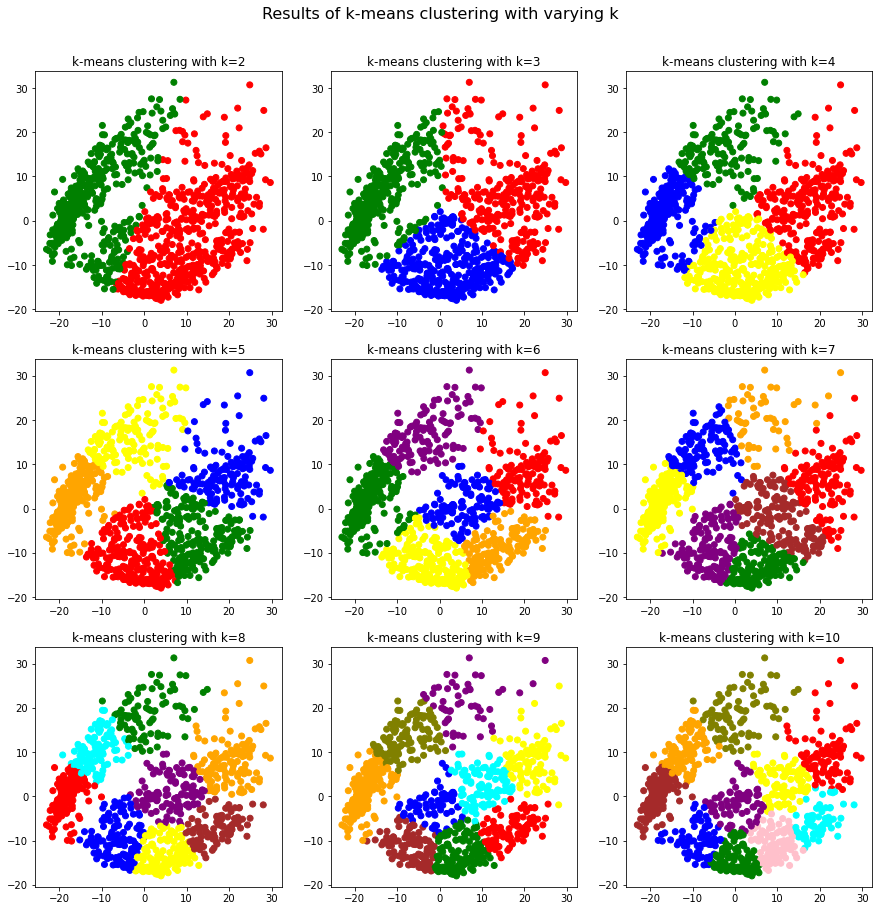

In [151]:
# plotting
plt.figure(figsize=(15, 15))
colors = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'orange', 5:'purple', 6:'brown', 7:'cyan', 8:'olive', 9:'pink'}
color_code = pd.Series(label_indices).map(colors)
W_list = []

for i in range(2, 11):
    plt.subplot(3, 3, (i-1))
    comp1, comp2, labels, centroids, W = k_means(X_pca, i, max_iter=30)
    W_list.append(W)
    color_code_fitted = pd.Series(labels).map(colors)
    plt.scatter(comp1, comp2, c=color_code_fitted)
    plt.title(f"k-means clustering with k={i}")
plt.suptitle("Results of k-means clustering with varying k", fontsize=16, y=0.94)

Text(0.5, 1, 'Within distance for each clustering')

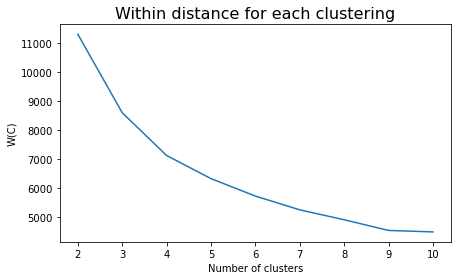

In [49]:
plt.figure(figsize=(7, 4))
plt.plot(np.linspace(2, 10, 9), W_list)
plt.xlabel("Number of clusters")
plt.ylabel("W(C)")
plt.title("Within distance for each clustering", fontsize=16, y=1)

<a name="q22"></a>

## 2.2 Clustering of the feature matrix [^](#outline)

We now turn our attention to another dataset, which is from a social network of bottlenose dolphins. The data was collected by marine biologists in New Zealand over several years, and is documented in the paper by David Lusseau and colleagues titled _"The bottlenose dolphin community of Doubtful Sound features
a large proportion of long-lasting associations"._ It consists of:
1. A set of features F (32 features for each of the 62 dolphins) capturing different traits of the dolphins
2. The social network of associations A among the dolphins
3. The dolphin names

In this section, we will investigate the feature matrix. We first employ hierarchical clustering to the feature matrix (section 2.2.1) and then look at a measure to evaluate the quality of the clustering: the silhouette score (section 2.2.2).

In [50]:
dolphin_names = pd.read_csv("dolphin_names.csv")
A = np.load("dolphins_A_62x62(1).npy")
F = np.load("dolphins_F_62x32(1).npy")
print(f"Shape of A: {A.shape}")
print(f"Shape of F: {F.shape}")

Shape of A: (62, 62)
Shape of F: (62, 32)


<a name="q221"></a>

### 2.2.1 Implementation of the hierarchical clustering algorithm [^](#outline)

Hierarchical clustering is widely used for data exploration, because it does not require the number of clusters to be pre-specified, yet produces a global description of the data structure. This is done in the form of a binary tree. We start from the discrete clustering, and proceed by merging clusters that are close to each other. At the end we arrive to the one cluster setting. The merging can be carried out using different criteria, below we will use average linkage.

We implement the hierarchical clustering algorithm in the function`hierarchical_clustering`. This is dependent of two auxiliary functions: `pairwise_distances`, where the used distance metric is Euclidean distance and `average_linkage`. We then report the found clusterings, from finest to coarsest.

In [184]:
def pairwise_distances(points):
    """Compute the pairwise distances of the data points.
    
    Inputs:
    points: A numpy array of points having the shape (N, D), 
            where N is the number of points and D is the number of features.
    Returns:
    distance: A numpy array with shape (N, N) such that the element (i, j) is the computed
              distance between i-th point and j-th point in X.
    """
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

def average_linkage(distances, cluster_assignment, i, j):
    """Compute the average linkage value between two clusters.
    
    Inputs:
        distances: A numpy array of pair-wise distances for the given points.
        cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
        i: the first cluster id.
        j: the second cluster id.
    Returns:
        The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()

def hierarchical_clustering(points, distances):
    """Perform hierarchical clustering on a dataset by successively merging clusters starting from the discrete clustering.

    Inputs:
        points: A numpy array of points having the shape (N, D), 
                where N is the number of points and D is the number of features.
        distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
                   distance between i-th point and j-th point in X.
        linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
        assigments: A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
                    The first row, i.e. a[0, :], represents the highest level of clustering 
                    where all columns have the same index value.
                    The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
                    The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = average_linkage(distances, current_assignment, cluster_i, cluster_j)    ## <-- EDIT THIS LINE
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)                
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        
    return assignments

In [185]:
d = pairwise_distances(F)
a = hierarchical_clustering(F, d)
a.shape

(62, 62)

In [186]:
cluster_df = pd.DataFrame(a[::-1][:-1], index=[f"Number of clusters={61-i}" for i in range(61)], columns=[f"Dolphin {i}" for i in range(1, 63)])
cluster_df

,Dolphin 1,Dolphin 2,Dolphin 3,Dolphin 4,Dolphin 5,Dolphin 6,Dolphin 7,Dolphin 8,Dolphin 9,Dolphin 10,...,Dolphin 53,Dolphin 54,Dolphin 55,Dolphin 56,Dolphin 57,Dolphin 58,Dolphin 59,Dolphin 60,Dolphin 61,Dolphin 62
Number of clusters=61,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0
Number of clusters=60,0.0,1.0,2.0,3.0,63.0,5.0,6.0,7.0,8.0,9.0,...,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0
Number of clusters=59,0.0,1.0,2.0,3.0,63.0,5.0,6.0,7.0,8.0,64.0,...,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0
Number of clusters=58,0.0,1.0,2.0,3.0,63.0,65.0,65.0,7.0,8.0,64.0,...,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0
Number of clusters=57,0.0,1.0,2.0,3.0,63.0,66.0,66.0,7.0,8.0,66.0,...,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Number of clusters=5,113.0,117.0,113.0,118.0,118.0,117.0,117.0,117.0,118.0,117.0,...,116.0,90.0,117.0,118.0,117.0,117.0,116.0,118.0,117.0,90.0
Number of clusters=4,113.0,117.0,113.0,118.0,118.0,117.0,117.0,117.0,118.0,117.0,...,119.0,119.0,117.0,118.0,117.0,117.0,119.0,118.0,117.0,119.0
Number of clusters=3,120.0,117.0,120.0,118.0,118.0,117.0,117.0,117.0,118.0,117.0,...,120.0,120.0,117.0,118.0,117.0,117.0,120.0,118.0,117.0,120.0
Number of clusters=2,121.0,117.0,121.0,121.0,121.0,117.0,117.0,117.0,121.0,117.0,...,121.0,121.0,117.0,121.0,117.0,117.0,121.0,121.0,117.0,121.0


<a name="q222"></a>

### 2.2.2 Evaluation measures of clustering: the Silhouette Score [^](#outline)
The evaluation of a clustering is a challenging task, because there is no ground truth to compare to. We now look at a measure for this called the Silhouette Score. It is defined as the mean Silhouette Coefficient over all samples, where the Silhouette Coefficient of a given sample is:
$$\text{Silhouette Coefficient} = \frac{d_2 - d_1}{\max{(d_1, d_2)}}.$$

Here $d_1$ denotes the average distance between the sample and the points in its cluster (excluding the point itself), and $d_2$ stands for the average distance between the sample and the points in the nearest cluster. If a cluster has only one point or there is only one cluster in the clustering, the Silhouette Coefficient is set to zero.

The functions `silhouette_coefficient` and `silhouette_score` implement this algorithm. We then use this measure to evaluate the clusterings obtained in the previous section. We also compare our implementation to `sklearn.metrics.silhouette_score`.

In [187]:
def silhouette_coefficient(distances, X, x_sample, cluster_assignment):
    """Find the Silhouette Coefficient of a given sample.
    
    Inputs:
        distances (ndarray shape (N, N)): The pair-wise distances for the given points.
        X (ndarray of shape (N, M)): the data matrix
        x_sample (ndarray of shape (N,)): the sample whose Silhouette Coefficient is to be computed
        cluster_assignment (ndarray of shape (N,)): the underlying clustering
    
    Returns:
        the Silhouette Coefficient for sample x_sample
    """
    x_index = np.where(X==x_sample)[0][0]
    x_label = cluster_assignment[x_index]
    x_cluster_indices = np.where(cluster_assignment == x_label)[0]
    
    # need these two lines to group point indices according to cluster
    cluster_assignment_unique = np.unique(cluster_assignment)
    x_cluster_index_unique = np.where(cluster_assignment_unique==x_label)[0][0]
     
    # group point indices in cluster_assignment accoring to label (length of list is the number of clusters)
    all_clusters = [np.where(cluster_assignment == label)[0] for label in cluster_assignment_unique]
    
    if len(x_cluster_indices)==1:
        return 0
    elif len(all_clusters) == 1:
        return 0
    
    dist_from_x = distances[x_index]
    d1 = np.sum(dist_from_x[x_cluster_indices]) / (len(x_cluster_indices)-1)
    
    cluster_distances = np.array([np.mean(dist_from_x[cluster]) for cluster in all_clusters])
    # reset distance from own cluster to ensure it's not selected as a minimum
    cluster_distances[x_cluster_index_unique] = np.inf
    d2 = np.amin(cluster_distances)
    
    return (d2 - d1)/np.maximum(d1, d2)


def silhouette_score(distances, X, cluster_assignment):
    """Return the Silhouette Score of a cluster assignment.
    
    Inputs:
        distances (ndarray shape (N, N)): The pair-wise distances for the given points.
        X (ndarray of shape (N, M)): the data matrix
        cluster_assignment (ndarray of shape (N,)): the underlying clustering
    Returns:
        The Silhouette Score (Silhouette Coefficient averaged over all samples of X)
    """
    return np.mean([silhouette_coefficient(distances, X, x_sample, cluster_assignment) for x_sample in X])

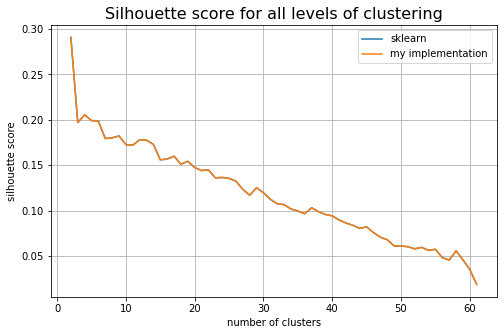

In [192]:
# sklearn version
import sklearn
# sklearn version
sklearn_scores = [sklearn.metrics.silhouette_score(d, labels=a[i], metric="precomputed") for i in range(2, len(a))]

# my implementation
distances = pairwise_distances(F)
# take array from 2 clusters as for 1 cluster sklearn implementation is not defined
scores = [silhouette_score(d, F, b) for b in a[1:]][1:]

plt.figure(figsize=(8, 5))
plt.plot(np.arange(2, 62), sklearn_scores, label='sklearn')
plt.plot(np.arange(2, 62), scores, label='my implementation')
plt.xlabel("number of clusters")
plt.ylabel("silhouette score")
plt.title("Silhouette score for all levels of clustering", fontsize=16, y=1)
plt.legend()
plt.grid()

In [191]:
print(f"Maximal silhouette score = {max(scores)}")
# array indexing goes from 0 but levels start from 2 as 1 is not defined in sklearn
print(f"Optimal number of clusters = {np.argmax(scores)+2}")

Maximal silhouette score = 0.2908121548656347
Optimal number of clusters = 2


The optimal number of clusters according to the silhouette score is one. As the number of clusters grows, the silhouette score decreases following a roughly linear trend, with no clear local maximum (only some similar bumps) after the fist peak. We should note, however, that our maximum value of $0.29$ is quite low, compared to the best possible value being 1 (although this is achieved only when $d_1=0$ for all samples, that is, points that are clustered together lie perfectly on top of each other). Indeed, the silhouette score takes values between -1 and 1, where the negative values indicate $d_1 > d_2$ for some samples, which means they were assigned to a cluster incorrectly.

The silhouette score operates on the feature matrix, thus we only predicted how the dolphins should cluster based on their recorded traits. The next section will analyze the social network graph of the dolphins that shows the actual social interactions of the dolphins.

<a name="q23"></a>

## 2.3 Graph-based analysis  [^](#outline)

This section is inspired by the paper by _Lusseau et al_. We to the dolphin social network given by the matrix `A`. We aim to understand the community structure by clustering the network into two groups, as well as investigating which dolphins are most 'central', i.e. have most crucial role in the community. 

In [58]:
from scipy.sparse import linalg
import networkx as nx
import seaborn as sns

<a name="q231"></a>

### 2.3.1 Spectral clustering [^](#outline)
We outline the spectral clustering algorithm for $k=2$ clusters, that is, for a bipartitioning the graph. We seek to minimize the cut size $C$. It is defined to be the number of edges needed to split the graph into two subgraphs $S_1$ and $S_2$, and is given by
$$C = \frac{1}{2} \sum_{i\in S_1, j \in S_2} A_{ij}.$$
With the notation 
$$s_i = \begin{cases} 
      +1 & i \in S_1 \\
      -1 & i \in S_2 
   \end{cases}.
$$
Let $D$ be the degree matrix of the graph. The symmetric normalized graph Laplacian is defined as
$$\mathcal{L} = I -  D^{-1/2}A D^{-1/2}.$$
With this we can rewrite the cut as
$$C = \frac{1}{4}s^T \mathcal{L} s,$$
and we need to minimize this (under some constraints that ensure that we indeed have a partition). The solution is given by $v_2$, the second smallest eigenvector of $L$ (the Fiedler eigenvector). The algorithm is as follows:
1. If we have a prescribed size for the clusters ($n_1$ and $n_2$), then the indices corresponding to the largest $n_1$ elements of $v_2$ are assigned to cluster 1, the rest to cluster 2
2. If we don't have $n_1$ and $n_2$ specified, then the indices of the negative values of $v_2$ are assigned to cluster 1, and the positive ones to cluster 2

The following cells carry out the spectral bipartitioning of the matrix `A`. One should note that the algorithm can be defined for the (regular) graph Laplacian $L = D-A$ as well. However, from the below plot we see that in our case, the Laplacian has very small values, thus the normalization is desired.

Text(0.5, 0.98, 'Comparison of the graph Laplacians')

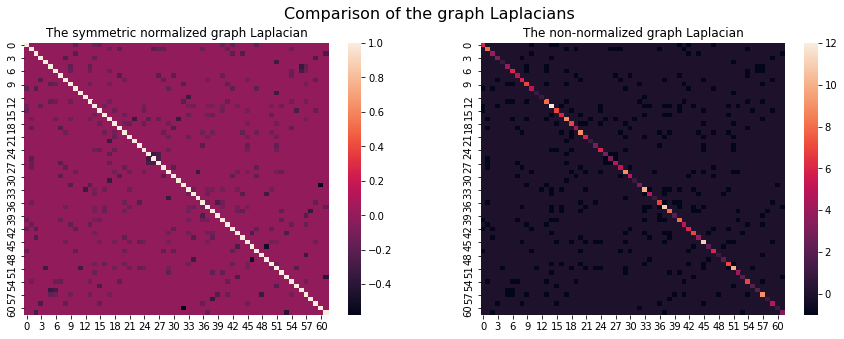

In [59]:
weighted_degree = A.sum(axis=1) 

# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))
# define the non-normalised Laplacian
L = np.diag(weighted_degree) - A

# visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(L_norm)
plt.title("The symmetric normalized graph Laplacian")
plt.subplot(1, 2, 2)
sns.heatmap(L)
plt.title("The non-normalized graph Laplacian")
plt.suptitle("Comparison of the graph Laplacians", fontsize=16)

The first eigenalue is: -2.1038702282086838e-16
The second eigenalue is: 0.03952455375743431


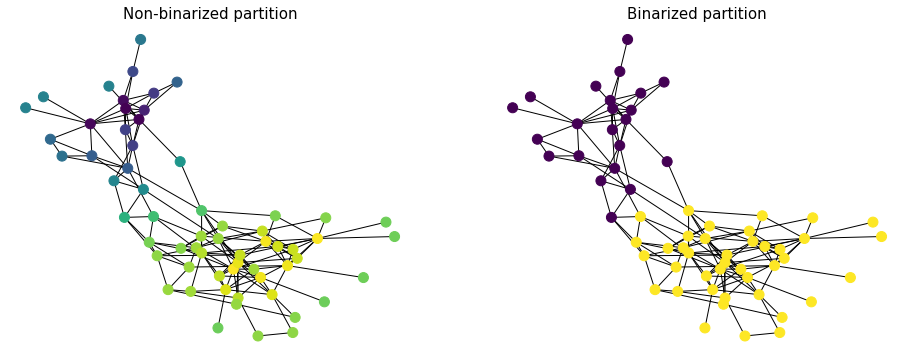

In [97]:
# visualizing the partition
eigenvals, eigenvecs = linalg.eigsh(L_norm, 2, which="SM", return_eigenvectors=True)
print('The first eigenalue is: {}'.format(eigenvals[0]))
print('The second eigenalue is: {}'.format(eigenvals[1]))
# extract the second eigenvector
second_eigenvector = eigenvecs[:,1]

spectral_partition = second_eigenvector.copy()
spectral_partition[spectral_partition<0] = 0
spectral_partition[spectral_partition>0] = 1


# draw the network structure coloured by the second eigenvector
g = nx.Graph(A)
np.random.seed(160699)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("Non-binarized partition", fontsize=15)
nx.draw(g,node_size=100,  node_color=second_eigenvector)

np.random.seed(160699)
plt.subplot(1, 2, 2)
plt.title("Binarized partition", fontsize=15)
nx.draw(g, node_size=100, node_color=spectral_partition)

<a name="q232"></a>

### 2.3.2 Measures of centrality: a comparison [^](#outline)
The aim of the concept of graph centrality is to rank the nodes in terms of importance in the network. Clearly, this is a somewhat subjective measure, hence there are many different versions of centrality. This section explores three of these: degree centrality, eigenvector centality and PageRank centrality. These concepts are implemented in the respective functions. They are then compared by their output on the dolphin social network. Finally, we will reflect on our results based on the paper by _Lusseau et al_.

We first define the centrality measures that we implement.
1. __Degree centrality__: the degree centrality of a node in a graph with $E$ edges with degree $g$ is given by
$$c_g = \frac{d}{2E} = \frac{A 1}{2E}.$$
2. __Eigenvector centrality__:  the eigenvector centrality of a node is given by the respective component of the leading eigenvector $\lambda$ of $A$:
$$Ac_e = \lambda c_e$$
3. __PageRank centrality__: a simple version of this is defined as
$$c_{\text{PR}}=\left(I- \alpha (AD^{-1}) \right)^{-1}(1-\alpha)\frac{1}{N}1,$$
where $\alpha$ is called the teleportation parameter, and is customarily set to $0.85$.

In [98]:
def degree_centrality(A):
    """Calculate the degree centrality of a graph given by its adjacency matrix."""
    E = np.sum(A)
    return A @ np.ones(A.shape[1]) / (2*E)

def eigen_centrality(A):
    """Calculate the eigenvector centrality of a graph given by its adjacency matrix."""
    eigenval, eigenvec = linalg.eigsh(A, 1, which="LA", return_eigenvectors=True)
    eigenvec = eigenvec.reshape(62,)
    # eigenvec has all elements with same sign (Perron-Frobenius), so take the positive version
    return abs(eigenvec)

def PageRank(A, alpha=0.85):
    """Calculate the PageRank centrality of a graph given by its adjacency matrix."""
    D = np.diag(A.sum(axis=1))
    PR = np.linalg.inv(np.identity(A.shape[0]) - alpha * (A @ np.linalg.inv(D))) @ (((1-alpha)/A.shape[0]) * np.ones(A.shape[0]))
    return PR

Text(0.5, 1, 'Comparison of centrality measures')

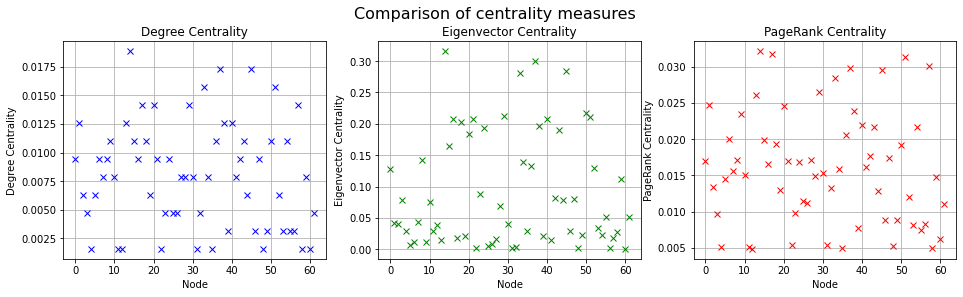

In [152]:
degree_centrality_arr = degree_centrality(A)
eigen_centrality_arr = eigen_centrality(A)
PageRank_arr = PageRank(A)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(range(62), degree_centrality_arr, 'bx' )
plt.xlabel("Node")
plt.ylabel("Degree Centrality")
plt.title("Degree Centrality")
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(range(62), eigen_centrality_arr, 'gx')
plt.xlabel("Node")
plt.ylabel("Eigenvector Centrality")
plt.title("Eigenvector Centrality")
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(range(62), PageRank_arr, 'rx')
plt.xlabel("Node")
plt.ylabel("PageRank Centrality")
plt.title("PageRank Centrality")
plt.grid()
plt.suptitle("Comparison of centrality measures", fontsize=16, y=1)

Mean of eigen/degree: 1.6089388527641917
Standard deviation of eigen/degree: 4.479440318081076
Mean of PageRank/degree: 1.0029968021439504
Standard deviation of PageRank/degree: 0.845051372417826


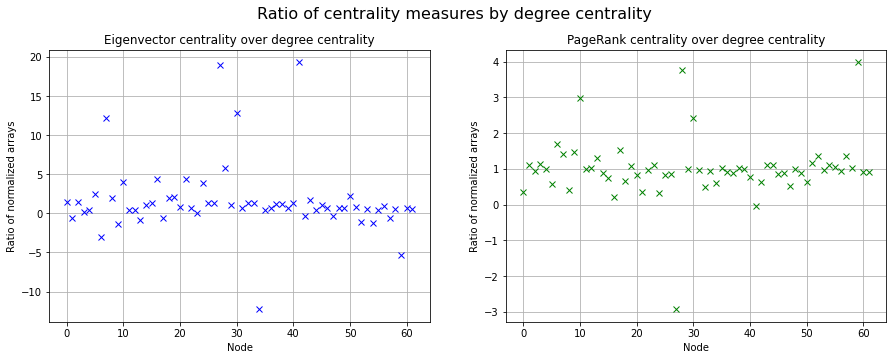

In [153]:
def norm(arr):
    return (arr-arr.mean())/arr.std()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(62), norm(eigen_centrality_arr)/norm(degree_centrality_arr), 'bx' )
plt.xlabel("Node")
plt.ylabel("Ratio of normalized arrays")
plt.title("Eigenvector centrality over degree centrality")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(62), norm(PageRank_arr)/norm(degree_centrality_arr), 'gx')
plt.xlabel("Node")
plt.ylabel("Ratio of normalized arrays")
plt.title("PageRank centrality over degree centrality")
plt.grid()
plt.suptitle("Ratio of centrality measures by degree centrality", fontsize=16, y=1)

print(f"Mean of eigen/degree: {np.mean(norm(eigen_centrality_arr)/norm(degree_centrality_arr))}")
print(f"Standard deviation of eigen/degree: {np.std(norm(eigen_centrality_arr)/norm(degree_centrality_arr))}")
print(f"Mean of PageRank/degree: {np.mean(norm(PageRank_arr)/norm(degree_centrality_arr))}")
print(f"Standard deviation of PageRank/degree: {np.std(norm(PageRank_arr)/norm(degree_centrality_arr))}")

In [100]:
# Comparison of most central dolphins
names = dolphin_names["name"].to_numpy()
df_centrality = pd.DataFrame(np.array([degree_centrality_arr, eigen_centrality_arr, PageRank_arr]).T,
                                       columns=["Degree Centrality", "Eigenvector Centrality", "PageRank Centrality"])

df_dolphins = pd.DataFrame(np.array([
    names[list(df_centrality["Degree Centrality"].nlargest(10).index.values)],
    names[list(df_centrality["Eigenvector Centrality"].nlargest(10).index.values)],
    names[list(df_centrality["PageRank Centrality"].nlargest(10).index.values)]]),
    index=["Degree Centrality", "Eigenvector Centrality", "PageRank Centrality"],
    columns=[i for i in range(1, 11)])

df_dolphins

,1,2,3,4,5,6,7,8,9,10
Degree Centrality,Grin,SN4,Topless,Scabs,Trigger,Jet,Kringel,Patchback,Web,Beescratch
Eigenvector Centrality,Grin,SN4,Topless,Scabs,TR99,Patchback,Trigger,Hook,SN9,MN105
PageRank Centrality,Grin,Jet,Trigger,Web,SN4,Topless,Scabs,Patchback,Gallatin,Beescratch


In [101]:
# Data for correlations
print("Correlations between Centrality Measures:")
df_centrality.corr()

Correlations between Centrality Measures:


,Degree Centrality,Eigenvector Centrality,PageRank Centrality
Degree Centrality,1.000000,0.719648,0.983095
Eigenvector Centrality,0.719648,1.000000,0.609417
PageRank Centrality,0.983095,0.609417,1.000000


Text(0.5, 1.02, 'Scatter Plot for Different Centrality Measures')

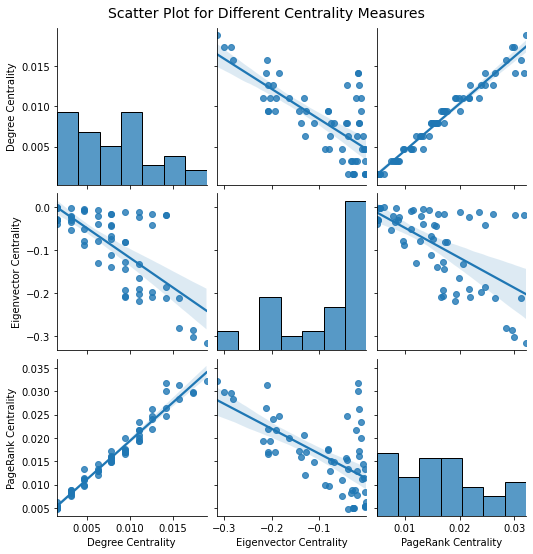

In [65]:
# Scatter plot between the measures:
sns.pairplot(df_centrality, kind='reg')
plt.suptitle("Scatter Plot for Different Centrality Measures", y=1.02, fontsize=14)

The above analysis shows that the three degree centrality measures are quite similar: they produce a similar-looking scatter, they have many names and positions in common in their ten most central dolphin lists.
We also see that the degree and PageRank centralities are remarkably similar, in the following ways:
1. On the ratio plots, most data points are very close to the line. The mean is within a 0.003 to 1, the standard deviation is around 0.85.
2. They have a correlation of 0.98
3. They are well-aligned on the pairplot.
This is rather surprising, because degree centrality is a very simple and somewhat uninteresting concept, whereas PageRank is much richer in theory. However, this might be partially due to the fact that our network is very small, and the advantages of PageRank may manifest at much higher scales - for which it was developed. 

Eigenvector centrality is less correlated to the degree and PageRank centralities, only achieving a correlation of around 0.72 and 0.61, respectively. The mean around 1.6 on the ratio scatter plot, with a higher variance of about 4.5. However, when looking at the ten most central dolphins, the first four entries perfectly match those of degree centrality. Their further positions don't match as well: they only have Trigger and Patchback in common. Thus it seems that the eigenvector and degree centralities work similarly for very central nodes, but strongly disagree in their results in the less obvious cases. On the other hand, degree and PageRank have small differences in the (unordered) set of the most central dolphins. However, they disagree on the exact ranking. Thus their similarity is sort of 'on average'.

The similarities in the results especially in the case of the most central nodes shows that there is consistency in the algorithms' idea of centrality. However, their perspectives are different, and thus they don't give completely matching results. Differences are most apparent for the less obvious cases (less important nodes). But in these cases, the accuracy of the ranking is less important, since these nodes don't have much role in the community anyway.

<a name="q233"></a>

### 2.3.3 Comparison of results to _Lusseau et al._ [^](#outline)

In the research paper, authors use clustering and centrality measures to shed light on the community structure of dolphins. In this section, we investigate the differences and similarities of their and our analysis.

__Data__

_Lousseau et al._ used a dataset different from our ones. Their data was constructed using a Half-weight Index (HWI) that quantified the association between all pairs of dolphins based on how many groups they were and weren't seen together in. This way they obtained a matrix. For centrality discussions, they have only kept the elements that are bigger than $0.47$ as they only considered these significant (see method below). They recorded associations that were significantly smaller than random (thus explicit non-associations). They constructed a sociogram $S$ from this, by connecting precisely those dolphins that had a HWI score above $0.47$. This resulted in 40 remaining dolphins. The strength of associationsbetween these were then ignored.

Our data is described above: it consists of a feature matrix for the dolphins and an adjacency matrix. The feature matrix seems unrelated. Our adjacency matrix is said to contain the frequent associations between dolphins. This contains 159 edges (318 1-s) and 72 dolphins. They however only identify 62 significantly strong associations among 40 dolphins, implying that the two adjacency matrices are not the same. Their adjacency matrix is not even a subgroup of ours. One can see on the below plot that Five has Trigger as his/her only connection, however in the paper, Five is only connected to Oscar. One could look at similarity measures _for graphs_ to see if the two adjacency matrices are even close (in some well-defined sense).

__Hierarchical Clustering__

They clustered the HWI matrix using hierarchical clustering with average linkage. The significance of the groups found in the cluster analysis, was assessed using a Monte Carlo randomisation approach. This allowed researchers to compare the actual HWI score to one arising from a random setting. It seems that thex have calculated averages of HWI scores in the clusters to assess the significance of the clusters. This did not reveal a clear community structure.

This conclusion is in accordance with our results on the (completely different) feature matrix and silhouette score metric.


__Centrality measures__

They seem to have used degree centrality on their sociogram (although they only refer to the degree itself, which lacks the scaling). The sociogram revealed three clusters of the dolphins. Their first band identifies six males and one female (Trigger), where Jonah and Topless are the central individuals. The second group is composed of eight males and one unknown sex individual (Ripplefluke), and Gallatin is in the central position. Finally, the third group is a female band consisting of nine individuals. (The remaining dolphins were in none of these groups).
 
Our adjacency matrix reveals a different structure. Although Jonas, Topless and Gallatin are central individuals according to our analysis, they are placed much lower on the degree centrality ranking (with the exception of Topless being third). Another example of the differences is that our centrality measures place Grin consistently as first, whereas in the paper's sociogram, Grin is not even the most central in her female gang (Scabs has more connections). 

This highlights the fact that it matters to check the differences between the data used in various analyses. It is also crucial where we draw the threshold between associations that are worth and not worth representing. One way to refine the analysis could be to weight the centrality measures by the strength of the association the edges correspond to. 

Below we plot our spectral partition again, endowed with the names of the dolphins. Node size is proportional to the dolphin's degree centrality.

Text(0.5, 1, 'The dolphin social network')

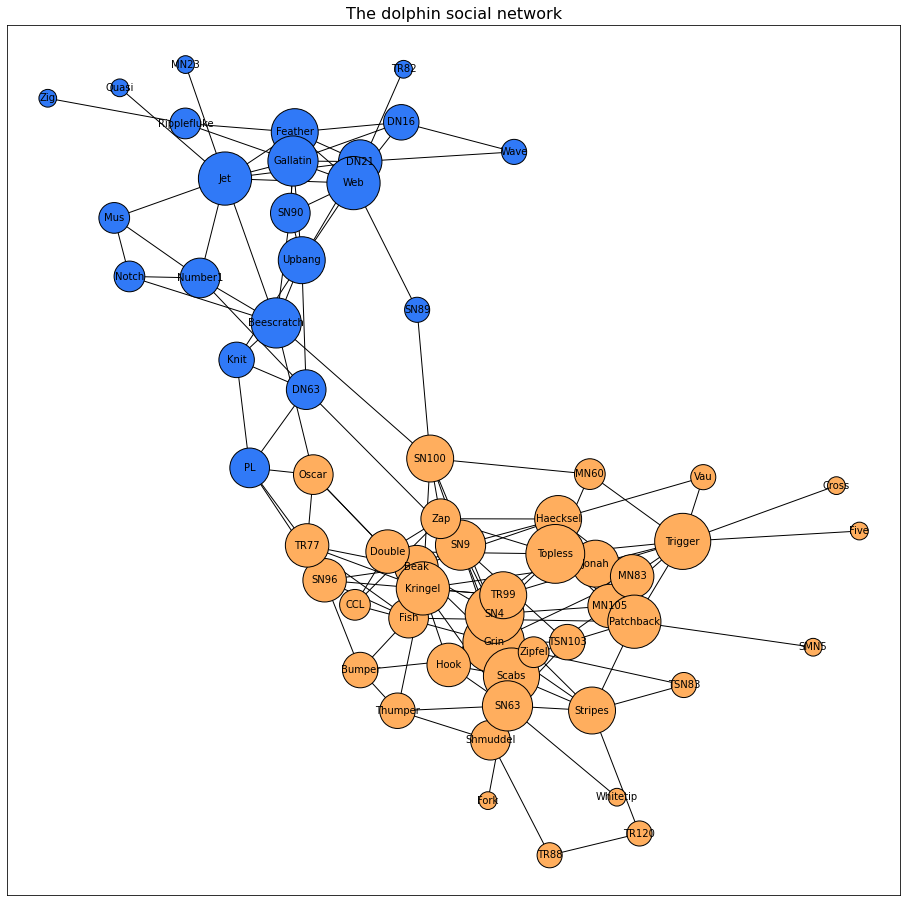

In [140]:
deg_centralities = list(df_centrality["Degree Centrality"])
labels = {} 
for idx, node in enumerate(g.nodes()): 
    labels[node] = names[idx] 

np.random.seed(160699)
plt.figure(figsize=(16, 16))
pos=nx.spring_layout(g, k=0.2) 
d = {}
for idx, node in enumerate(g.nodes()): 
    d[node] = deg_centralities[idx] 

nodes = nx.draw_networkx_nodes(g, pos,  node_size=[v * 2*10**5 for v in d.values()], node_shape='o', 
                       node_color=cm.rainbow(spectral_partition*0.6+0.16)) 
nodes.set_edgecolor('black')
nx.draw_networkx_edges(g, pos) 
lab = nx.draw_networkx_labels(g, pos, labels, font_size=10)
plt.title("The dolphin social network", fontsize=16, y=1)

<a name="q3"></a>

# 3 Conclusion [^](#outline)
In this notebook, we explored various supervised, semi-supervised and unsupervised learning methods. The notebook illustrates the range of algorithms available, as well as their strengths and limitations. 